In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '20 days CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Cyclic Stocks

### Singapore Airlines

In [8]:
nr_test_sets = ['C6L.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2018-12-14         9.52  9.466080 -53.571343 -82078567.0     2.0
2018-12-17         9.33  9.445145 -87.500043 -84305791.0     2.0
2018-12-18         9.45  9.445892 -64.814890 -82764591.0     2.0
2018-12-19         9.39  9.437293 -75.925903 -84460291.0     2.0
2018-12-20         9.37  9.426940 -75.000054 -85913091.0     2.0


In [9]:
r_test_sets = ['C6L.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-12-16         9.13  9.083831 -44.117515 -5009999.0     2.0
2019-12-17         9.12  9.089395 -43.750019 -5679099.0     2.0
2019-12-18         9.12  9.094104 -33.333333 -5679099.0     2.0
2019-12-19         9.12  9.098088 -33.333333 -5679099.0     2.0
2019-12-20         9.05  9.090690 -57.692110 -6968099.0     1.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


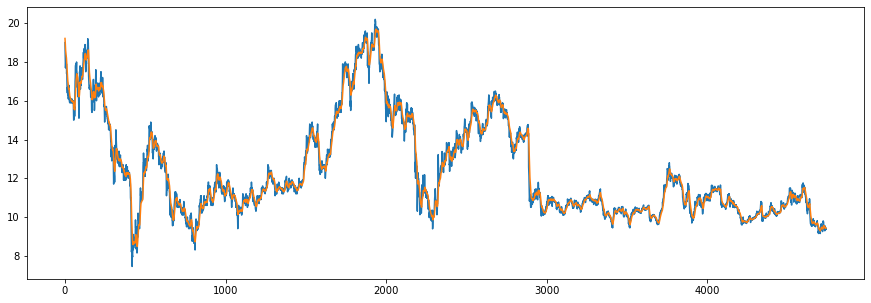

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/C6L.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [11]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4720, 20, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4720, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 4292, 0.0: 215, 1.0: 213})

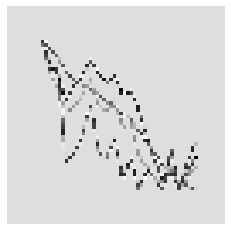

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('C6L.SI')]
    y = nr_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('C6L.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('C6L.SI')]
    y = r_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.317829457364341, 1: 7.403921568627451, 2: 0.36653077072413126}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.2419 - accuracy: 0.3665 - mse: 1.6651 - weighted_accuracy: 0.3288 - weighted_mse: 1.7120 - val_loss: 0.2054 - val_accuracy: 0.0636 - val_mse: 0.9050 - val_weighted_accuracy: 0.0636 - val_weighted_mse: 0.9050
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2073 - accuracy: 0.2233 - mse: 1.1829 - weighted_accuracy: 0.3177 - weighted_mse: 1.1744 - val_loss: 0.2139 - val_accuracy: 0.0456 - val_mse: 0.9210 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.9210
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2066 - accuracy: 0.2172 - mse: 1.1914 - weighted_accuracy: 0.3341 - weighted_mse: 1.1644 - val_loss: 0.2094 - val_accuracy: 0.0456 - val_mse: 0.9219 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.9219
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 6ms/step - loss: 0.1955 - accuracy: 0.1721 - mse: 0.9604 - weighted_accuracy: 0.1721 - weighted_mse: 0.9604
Test loss: 0.1955426186323166
Test accuracy: 0.17209301888942719


number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 105
actual holds but predicted sell: 64
actual predicted holds: 29
Percentage buys correct: 4.424778761061947%
Percentage sells correct: 4.477611940298507%
Percentage holds correct: 82.85714285714286%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 39.285714285714285%
Percentage high sells correct: 53.73134328358209%
Percentage mid holds correct: 71.42857142857143%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price 

<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1992 - accuracy: 0.2373 - mse: 1.2007 - weighted_accuracy: 0.3371 - weighted_mse: 1.1765 - val_loss: 0.2012 - val_accuracy: 0.0519 - val_mse: 1.0728 - val_weighted_accuracy: 0.0519 - val_weighted_mse: 1.0728
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2004 - accuracy: 0.3046 - mse: 1.2071 - weighted_accuracy: 0.3544 - weighted_mse: 1.2002 - val_loss: 0.1957 - val_accuracy: 0.3114 - val_mse: 0.9311 - val_weighted_accuracy: 0.3114 - val_weighted_mse: 0.9311
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1981 - accuracy: 0.2643 - mse: 1.1856 - weighted_accuracy: 0.3710 - weighted_mse: 1.1786 - val_loss: 0.2047 - val_accuracy: 0.0614 - val_mse: 0.9759 - val_weighted_accuracy: 0.0614 - val_weighted_mse: 0.9759
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1981 - accuracy: 0.3565 - mse: 1.1882 - weighted_accuracy: 0.3492 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.4279 - mse: 0.9237 - weighted_accuracy: 0.4279 - weighted_mse: 0.9237
Test loss: 0.18747644126415253
Test accuracy: 0.42790699005126953




<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 92
actual holds but predicted sell: 22
actual predicted holds: 84
Percentage buys correct: 5.0%
Percentage sells correct: 12.0%
Percentage holds correct: 93.33333333333333%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 41.41414141414141%
Percentage high sells correct: 56.0%
Percentage mid holds correct: 82.22222222222223%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously bought: -46.06907216098063%
Share price: $0.5371028452205273
Shares owned at the moment: 0
Cash capital at the moment: $53.971703288518675


Share price: $0.524018700751522
Shares owned at the moment: 102
Cash capital at the moment: 

30/30 [==============================] - 0s 11ms/step - loss: 0.1783 - accuracy: 0.1578 - mse: 1.3063 - weighted_accuracy: 0.5043 - weighted_mse: 1.2569 - val_loss: 0.1953 - val_accuracy: 0.1091 - val_mse: 1.1534 - val_weighted_accuracy: 0.1091 - val_weighted_mse: 1.1534
Epoch 20/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1781 - accuracy: 0.1586 - mse: 1.2827 - weighted_accuracy: 0.5084 - weighted_mse: 1.2545 - val_loss: 0.2002 - val_accuracy: 0.0731 - val_mse: 0.9995 - val_weighted_accuracy: 0.0731 - val_weighted_mse: 0.9995
Validation loss: 0.20015911757946014
Validation accuracy: 0.0730932205915451


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2011 - accuracy: 0.0688 - mse: 0.9996 - weighted_accuracy: 0.0688 - weighted_mse: 0.9996
Test loss: 0.20105445384979248
Test accuracy: 0.06880734115839005


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual

7/7 [==============================] - 0s 4ms/step - loss: 0.2000 - accuracy: 0.0558 - mse: 0.9899 - weighted_accuracy: 0.0558 - weighted_mse: 0.9899
Test loss: 0.20002096891403198
Test accuracy: 0.055813953280448914


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 123
actual holds but predicted sell: 74
actual predicted holds: 1
Percentage buys correct: 4.511278195488722%
Percentage sells correct: 6.172839506172839%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 40.15151515151515%
Percentage high sells correct: 49.382716049382715%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previousl

<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1790 - accuracy: 0.1523 - mse: 1.2975 - weighted_accuracy: 0.5079 - weighted_mse: 1.2554 - val_loss: 0.1997 - val_accuracy: 0.1081 - val_mse: 1.1050 - val_weighted_accuracy: 0.1081 - val_weighted_mse: 1.1050
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1764 - accuracy: 0.1594 - mse: 1.3026 - weighted_accuracy: 0.5161 - weighted_mse: 1.2783 - val_loss: 0.1975 - val_accuracy: 0.1176 - val_mse: 1.0707 - val_weighted_accuracy: 0.1176 - val_weighted_mse: 1.0707
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1754 - accuracy: 0.1512 - mse: 1.2635 - weighted_accuracy: 0.5076 - weighted_mse: 1.2123 - val_loss: 0.1959 - val_accuracy: 0.1367 - val_mse: 1.1320 - val_weighted_accuracy: 0.1367 - val_weighted_mse: 1.1320
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1725 - accuracy: 0.1549 - mse: 1.3314 - weighted_accuracy: 0.5403 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1971 - accuracy: 0.1070 - mse: 1.1149 - weighted_accuracy: 0.1070 - weighted_mse: 1.1149
Test loss: 0.19705830514431
Test accuracy: 0.10697674751281738


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 3
actual sells but predicted hold: 1
actual holds but predicted buy: 137
actual holds but predicted sell: 47
actual predicted holds: 14
Percentage buys correct: 4.054054054054054%
Percentage sells correct: 5.769230769230769%
Percentage holds correct: 93.33333333333333%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 38.775510204081634%
Percentage high sells correct: 48.07692307692308%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from p

<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu




RUNNING EPOCHS 80 - 100



Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1645 - accuracy: 0.1589 - mse: 1.3937 - weighted_accuracy: 0.5548 - weighted_mse: 1.3460 - val_loss: 0.1957 - val_accuracy: 0.1684 - val_mse: 1.1856 - val_weighted_accuracy: 0.1684 - val_weighted_mse: 1.1856
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1622 - accuracy: 0.1748 - mse: 1.4145 - weighted_accuracy: 0.5679 - weighted_mse: 1.3721 - val_loss: 0.1941 - val_accuracy: 0.1833 - val_mse: 1.2243 - val_weighted_accuracy: 0.1833 - val_weighted_mse: 1.2243
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1625 - accuracy: 0.1822 - mse: 1.4234 - weighted_accuracy: 0.5819 - weighted_mse: 1.3881 - val_loss: 0.1958 - val_accuracy: 0.1780 - val_mse: 1.2030 - val_weighted_accuracy: 0.1780 - val_weighted_mse: 1.2030
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1622 - accuracy: 0.1645 - mse: 1.4348 - weight

7/7 [==============================] - 0s 2ms/step - loss: 0.1903 - accuracy: 0.3070 - mse: 1.2809 - weighted_accuracy: 0.3070 - weighted_mse: 1.2809
Test loss: 0.19027531147003174
Test accuracy: 0.3069767355918884




<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 100
actual holds but predicted sell: 40
actual predicted holds: 58
Percentage buys correct: 4.672897196261682%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 92.06349206349206%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 39.25233644859813%
Percentage high sells correct: 51.111111111111114%
Percentage mid holds correct: 80.64516129032258%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: 0.09623164985612664%
Share price: $1.01
Shares owned at the moment: 0
Cash capital at the moment: $99.82115701966835


Share price: $0.9931775412724846
Shares owned at the moment: 100


Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1485 - accuracy: 0.2709 - mse: 1.6081 - weighted_accuracy: 0.5997 - weighted_mse: 1.6286 - val_loss: 0.1896 - val_accuracy: 0.3072 - val_mse: 1.3293 - val_weighted_accuracy: 0.3072 - val_weighted_mse: 1.3293
Epoch 10/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1448 - accuracy: 0.2770 - mse: 1.6320 - weighted_accuracy: 0.6314 - weighted_mse: 1.7268 - val_loss: 0.1866 - val_accuracy: 0.3326 - val_mse: 1.4031 - val_weighted_accuracy: 0.3326 - val_weighted_mse: 1.4031
Epoch 11/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1452 - accuracy: 0.2749 - mse: 1.6406 - weighted_accuracy: 0.6214 - weighted_mse: 1.7325 - val_loss: 0.1843 - val_accuracy: 0.3665 - val_mse: 1.3699 - val_weighted_accuracy: 0.3665 - val_weighted_mse: 1.3699
Epoch 12/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1411 - accuracy: 0.3067 - mse: 1.6582 - weighted_accuracy: 0.6460 - weigh

7/7 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.4884 - mse: 1.4150 - weighted_accuracy: 0.4884 - weighted_mse: 1.4150


<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.17136187851428986
Test accuracy: 0.4883720874786377


number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 65
actual holds but predicted sell: 34
actual predicted holds: 99
Percentage buys correct: 4.285714285714286%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 92.5233644859813%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 41.42857142857143%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.90566037735849%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: 0.09623164985612664%
Share price: $1.01
Shares owned at the moment: 0
Cash capital at the moment: $99.82115701966835


Share price: $

Epoch 13/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1412 - accuracy: 0.3930 - mse: 1.7489 - weighted_accuracy: 0.6144 - weighted_mse: 1.9562 - val_loss: 0.1741 - val_accuracy: 0.4841 - val_mse: 1.4953 - val_weighted_accuracy: 0.4841 - val_weighted_mse: 1.4953
Epoch 14/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1351 - accuracy: 0.4031 - mse: 1.8712 - weighted_accuracy: 0.6775 - weighted_mse: 2.1005 - val_loss: 0.1694 - val_accuracy: 0.5011 - val_mse: 1.5041 - val_weighted_accuracy: 0.5011 - val_weighted_mse: 1.5041
Epoch 15/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1363 - accuracy: 0.4076 - mse: 1.8164 - weighted_accuracy: 0.6478 - weighted_mse: 2.0520 - val_loss: 0.1667 - val_accuracy: 0.5381 - val_mse: 1.4995 - val_weighted_accuracy: 0.5381 - val_weighted_mse: 1.4995
Epoch 16/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1313 - accuracy: 0.4033 - mse: 1.8419 - weighted_accuracy: 0.6720 - weig

<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 47
actual holds but predicted sell: 25
actual predicted holds: 126
Percentage buys correct: 5.769230769230769%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 94.02985074626865%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 42.30769230769231%
Percentage high sells correct: 48.275862068965516%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously bought: -82.43874948804242%
Share price: $0.1748940356405032
Shares owned at the moment: 0
Cash capital at the moment: $17.850429753150774


Share price: $0.19317757692386173
Shares owned at

30/30 [==============================] - 0s 11ms/step - loss: 0.1305 - accuracy: 0.5061 - mse: 2.1073 - weighted_accuracy: 0.6560 - weighted_mse: 2.5481 - val_loss: 0.1517 - val_accuracy: 0.6409 - val_mse: 1.6231 - val_weighted_accuracy: 0.6409 - val_weighted_mse: 1.6231
Epoch 19/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1262 - accuracy: 0.5087 - mse: 2.0819 - weighted_accuracy: 0.6792 - weighted_mse: 2.5160 - val_loss: 0.1518 - val_accuracy: 0.6388 - val_mse: 1.6203 - val_weighted_accuracy: 0.6388 - val_weighted_mse: 1.6203
Epoch 20/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1230 - accuracy: 0.5180 - mse: 2.0641 - weighted_accuracy: 0.6938 - weighted_mse: 2.6004 - val_loss: 0.1513 - val_accuracy: 0.6409 - val_mse: 1.6165 - val_weighted_accuracy: 0.6409 - val_weighted_mse: 1.6165
Validation loss: 0.15129399299621582
Validation accuracy: 0.6408898234367371


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0

<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 39
actual holds but predicted sell: 15
actual predicted holds: 144
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 92.90322580645162%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 37.2093023255814%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 84.41558441558442%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -2.682411235577087%
Share price: $0.981962687625398
Shares owned at the moment: 0
Cash capital at the moment: $97.05309625287674


Share price: $0.9931775412724846
Shares owned at the m

30/30 [==============================] - 0s 12ms/step - loss: 0.1176 - accuracy: 0.5673 - mse: 2.3888 - weighted_accuracy: 0.7081 - weighted_mse: 3.1245 - val_loss: 0.1340 - val_accuracy: 0.7511 - val_mse: 1.8832 - val_weighted_accuracy: 0.7511 - val_weighted_mse: 1.8832
Epoch 19/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1144 - accuracy: 0.5691 - mse: 2.4266 - weighted_accuracy: 0.7329 - weighted_mse: 3.2534 - val_loss: 0.1295 - val_accuracy: 0.7701 - val_mse: 1.8767 - val_weighted_accuracy: 0.7701 - val_weighted_mse: 1.8767
Epoch 20/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1166 - accuracy: 0.5842 - mse: 2.4955 - weighted_accuracy: 0.7274 - weighted_mse: 3.4128 - val_loss: 0.1371 - val_accuracy: 0.7331 - val_mse: 1.8423 - val_weighted_accuracy: 0.7331 - val_weighted_mse: 1.8423
Validation loss: 0.13710753619670868
Validation accuracy: 0.7330508232116699


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0

<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 24
actual holds but predicted sell: 9
actual predicted holds: 165
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 92.69662921348315%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 85.31073446327683%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously bought: -89.42402106625077%
Share price: $0.10532710272044075
Shares owned at the moment: 0
Cash capital at the moment: $10.91286736769755


Share price: $0.09224300281565666
Shares owned at 

30/30 [==============================] - 0s 11ms/step - loss: 0.1041 - accuracy: 0.6316 - mse: 2.9028 - weighted_accuracy: 0.7708 - weighted_mse: 4.1198 - val_loss: 0.1230 - val_accuracy: 0.7839 - val_mse: 2.1042 - val_weighted_accuracy: 0.7839 - val_weighted_mse: 2.1042
Validation loss: 0.12303490191698074
Validation accuracy: 0.7838982939720154


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1240 - accuracy: 0.7523 - mse: 2.0492 - weighted_accuracy: 0.7523 - weighted_mse: 2.0492
Test loss: 0.124031662940979
Test accuracy: 0.752293586730957


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 17
actual holds but predicted sell: 21
actual predicted holds: 162
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 4.545454545454546%
Percentage 

<ipython-input-21-f7c71854d178>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-f7c71854d178>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-f7c71854d178>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [22]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.172093,4.424779,4.477612,82.857143,39.285714,53.731343,71.428571,-77.568095,-78.238355
1,0.427907,5.000000,12.000000,93.333333,41.414141,56.000000,82.222222,-75.493806,-78.238355
2,0.055814,4.511278,6.172840,100.000000,40.151515,49.382716,100.000000,-86.504655,-78.238355
3,0.106977,4.054054,5.769231,93.333333,38.775510,48.076923,80.000000,-93.218194,-78.238355
4,0.306977,4.672897,6.666667,92.063492,39.252336,51.111111,80.645161,-83.854755,-78.238355
5,0.488372,4.285714,7.894737,92.523364,41.428571,50.000000,84.905660,-91.322492,-78.238355
6,0.613953,5.769231,10.344828,94.029851,42.307692,48.275862,85.714286,-91.089278,-78.238355
7,0.688372,4.651163,11.764706,92.903226,37.209302,52.941176,84.415584,-86.815510,-78.238355
8,0.786047,7.692308,18.181818,92.696629,53.846154,63.636364,85.310734,-65.325049,-78.238355
9,0.841860,11.764706,25.000000,93.157895,52.941176,62.500000,86.243386,-71.806486,-78.238355


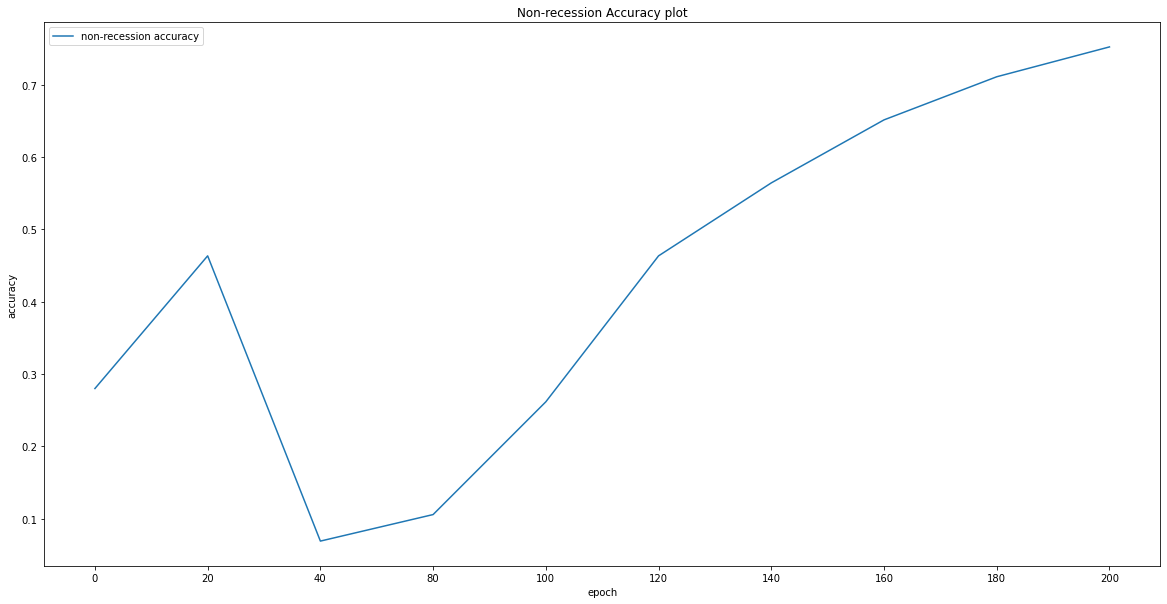

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

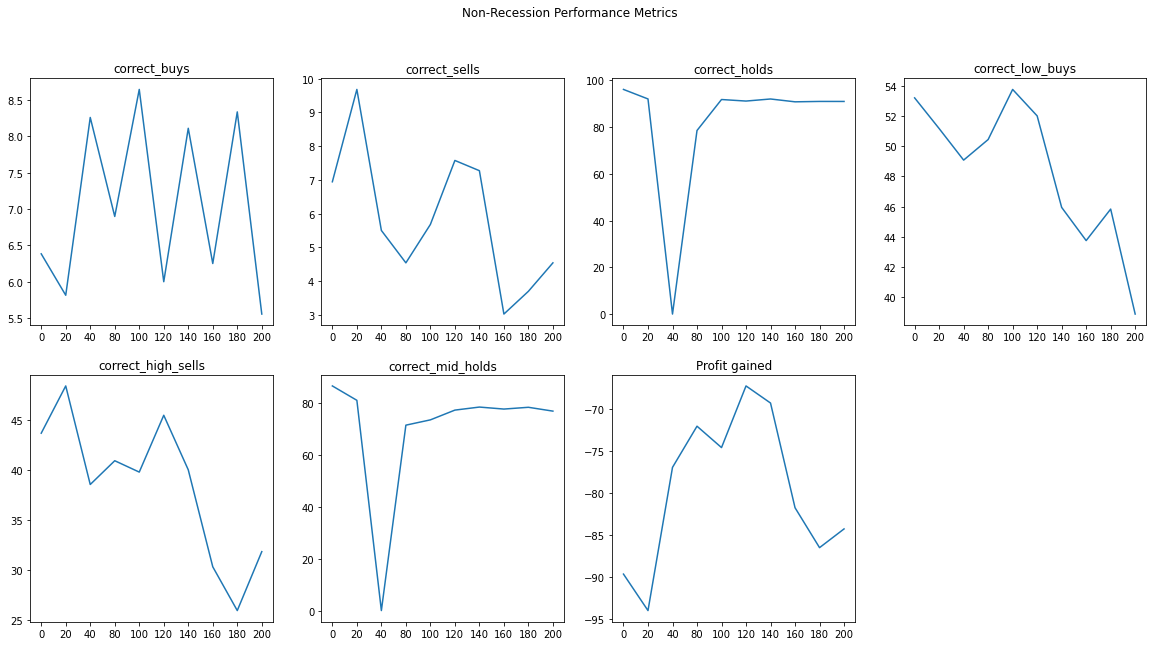

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

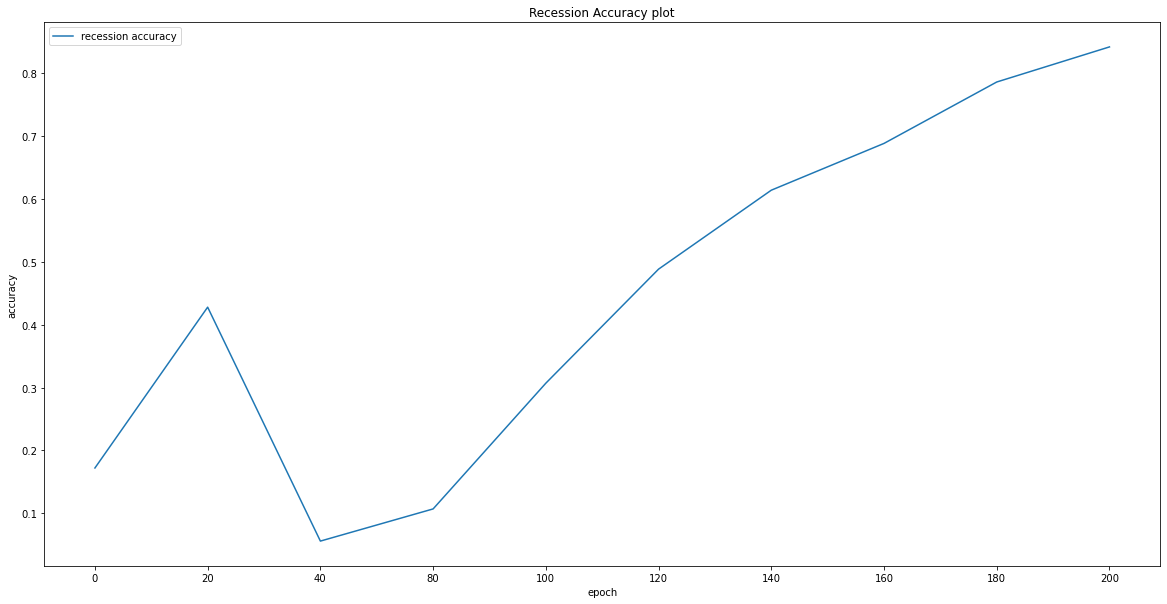

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

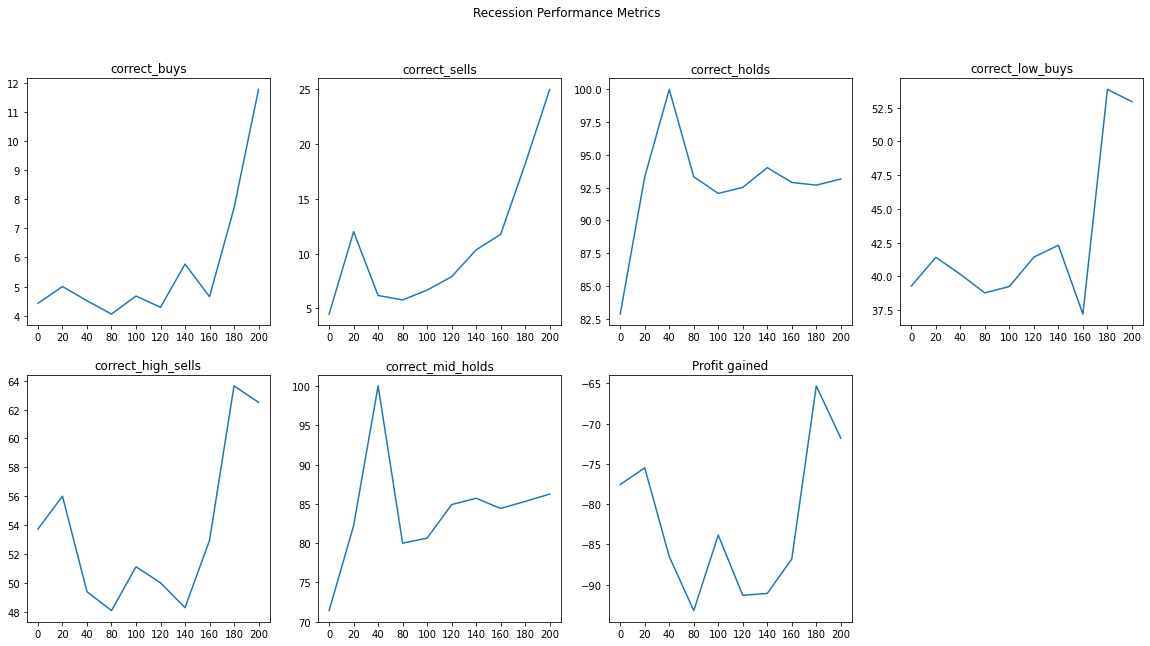

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### OCBC Bank

In [98]:
nr_test_sets = ['O39.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-14        11.29  11.223146 -41.249981  448131022.0     2.0
2018-12-17        11.12  11.207277 -80.645176  443153122.0     0.0
2018-12-18        11.34  11.227696 -45.161256  448093822.0     2.0
2018-12-19        11.15  11.215743 -75.806509  440428782.0     2.0
2018-12-20        11.14  11.204090 -77.419295  435151482.0     2.0


In [99]:
r_test_sets = ['O39.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-12-16        10.97  10.791319 -18.367351  53474942.0     2.0
2019-12-17        10.91  10.809578 -30.612316  49577542.0     2.0
2019-12-18        10.89  10.821951 -34.693842  45681342.0     2.0
2019-12-19        10.96  10.843189 -20.408211  50188142.0     2.0
2019-12-20        10.95  10.859621 -22.449071  47197442.0     2.0


### training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


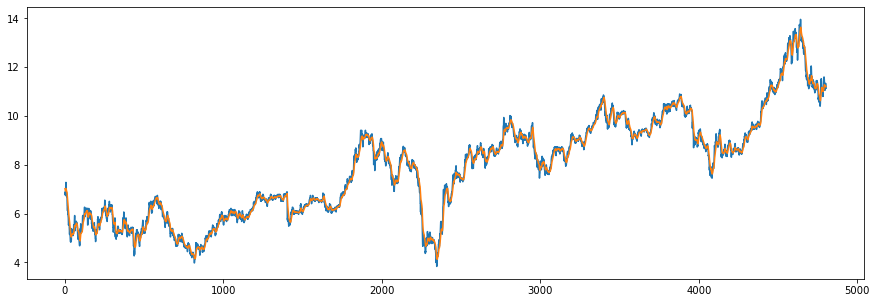

(4784, 64, 64, 1)

In [100]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/O39.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

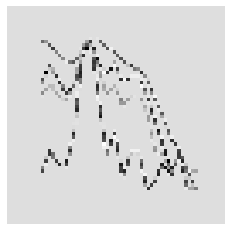

In [101]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [102]:
X = X/255

In [103]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [104]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [105]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [106]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [107]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('O39.SI')]
    y = nr_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('O39.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('O39.SI')]
    y = r_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2481060606060606, 1: 7.923395445134576, 2: 0.3655205348615091}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2439 - accuracy: 0.2621 - mse: 1.6416 - weighted_accuracy: 0.3292 - weighted_mse: 1.6474 - val_loss: 0.2205 - val_accuracy: 0.0418 - val_mse: 0.9550 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.9550
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2139 - accuracy: 0.2096 - mse: 1.1751 - weighted_accuracy: 0.3210 - weighted_mse: 1.1458 - val_loss: 0.2241 - val_accuracy: 0.0439 - val_mse: 1.0389 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 1.0389
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2062 - accuracy: 0.2652 - mse: 1.1814 - weighted_accuracy: 0.3479 - weighted_mse: 1.1496 - val_loss: 0.2009 - val_accuracy: 0.0418 - val_mse: 0.9917 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.9917
Epoch 4/20
30/30 [==============================] - 0s

0         -55.902029  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2014 - accuracy: 0.0651 - mse: 0.9735 - weighted_accuracy: 0.0651 - weighted_mse: 0.9735
Test loss: 0.20141784846782684
Test accuracy: 0.0651162788271904


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 6
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 70
actual holds but predicted sell: 123
actual predicted holds: 0
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 5.839416058394161%
Percentage holds correct: 0%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 43.58974358974359%
Percentage high sells correct: 45.588235294117645%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9978048904590266
Shares owned at the moment: 99
Cash capital at the moment: $0.94566346312889

<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2011 - accuracy: 0.2819 - mse: 1.1816 - weighted_accuracy: 0.3379 - weighted_mse: 1.1725 - val_loss: 0.1958 - val_accuracy: 0.0679 - val_mse: 1.0390 - val_weighted_accuracy: 0.0679 - val_weighted_mse: 1.0390
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1988 - accuracy: 0.2707 - mse: 1.1690 - weighted_accuracy: 0.4017 - weighted_mse: 1.1781 - val_loss: 0.1996 - val_accuracy: 0.0575 - val_mse: 0.9698 - val_weighted_accuracy: 0.0575 - val_weighted_mse: 0.9698
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1997 - accuracy: 0.2799 - mse: 1.1701 - weighted_accuracy: 0.3763 - weighted_mse: 1.1779 - val_loss: 0.2008 - val_accuracy: 0.0617 - val_mse: 1.0068 - val_weighted_accuracy: 0.0617 - val_weighted_mse: 1.0068
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1979 - accuracy: 0.2678 - mse: 1.1661 - weighted_accuracy: 0.3989 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1982 - accuracy: 0.0837 - mse: 1.0261 - weighted_accuracy: 0.0837 - weighted_mse: 1.0261
Test loss: 0.1982283890247345
Test accuracy: 0.08372092992067337


number of predictions: 215
actual predicted buys: 10
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 92
actual holds but predicted sell: 101
actual predicted holds: 0
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 7.207207207207207%
Percentage holds correct: 0%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.03846153846154%
Percentage high sells correct: 49.09090909090909%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9978048904590266
Shares owned at the moment: 99
Cash capital at the moment: $0.9456634631288949


Price increase from previously bought:

<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 0s 10ms/step - loss: 0.1863 - accuracy: 0.1921 - mse: 1.2553 - weighted_accuracy: 0.4988 - weighted_mse: 1.2034 - val_loss: 0.1969 - val_accuracy: 0.0637 - val_mse: 1.0178 - val_weighted_accuracy: 0.0637 - val_weighted_mse: 1.0178
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1898 - accuracy: 0.1837 - mse: 1.2523 - weighted_accuracy: 0.4553 - weighted_mse: 1.1991 - val_loss: 0.1993 - val_accuracy: 0.0658 - val_mse: 0.9840 - val_weighted_accuracy: 0.0658 - val_weighted_mse: 0.9840
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1868 - accuracy: 0.1748 - mse: 1.2651 - weighted_accuracy: 0.4569 - weighted_mse: 1.2180 - val_loss: 0.1978 - val_accuracy: 0.0617 - val_mse: 1.0160 - val_weighted_accuracy: 0.0617 - val_weighted_mse: 1.0160
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1865 - accuracy: 0.1698 - mse: 1.2457 - weighted_accuracy: 0.4876 - weighted_mse: 1.2042 -

7/7 [==============================] - 0s 2ms/step - loss: 0.1976 - accuracy: 0.0884 - mse: 1.1087 - weighted_accuracy: 0.0884 - weighted_mse: 1.1087
Test loss: 0.19760949909687042
Test accuracy: 0.08837209641933441




<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 215
actual predicted buys: 10
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 111
actual holds but predicted sell: 79
actual predicted holds: 3
Percentage buys correct: 8.0%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 100.0%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.58064516129032%
Percentage high sells correct: 47.12643678160919%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9978048904590266
Shares owned at the moment: 99
Cash capital at the moment: $0.9456634631288949


Price increase from previously bought: 0.03047193786460678%
Share price: $1.0008537405328568
Shares owned at the moment: 0
Cash capital at the moment: $99.75770134502164


Share price: $0.9581707117622773
Shares owned at the moment: 103
Cash capital at the mome

30/30 [==============================] - 0s 10ms/step - loss: 0.1711 - accuracy: 0.1761 - mse: 1.3667 - weighted_accuracy: 0.5512 - weighted_mse: 1.2987 - val_loss: 0.1975 - val_accuracy: 0.1202 - val_mse: 1.1925 - val_weighted_accuracy: 0.1202 - val_weighted_mse: 1.1925
Epoch 8/20
30/30 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.1670 - mse: 1.3604 - weighted_accuracy: 0.5366 - weighted_mse: 1.309 - 0s 9ms/step - loss: 0.1688 - accuracy: 0.1680 - mse: 1.3684 - weighted_accuracy: 0.5439 - weighted_mse: 1.3134 - val_loss: 0.1975 - val_accuracy: 0.1097 - val_mse: 1.1740 - val_weighted_accuracy: 0.1097 - val_weighted_mse: 1.1740
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1640 - accuracy: 0.1751 - mse: 1.4386 - weighted_accuracy: 0.5610 - weighted_mse: 1.3819 - val_loss: 0.1988 - val_accuracy: 0.1400 - val_mse: 1.2226 - val_weighted_accuracy: 0.1400 - val_weighted_mse: 1.2226
Epoch 10/20
30/30 [==============================] - 0s 

7/7 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.1349 - mse: 1.2480 - weighted_accuracy: 0.1349 - weighted_mse: 1.2480
Test loss: 0.20585443079471588
Test accuracy: 0.13488371670246124


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 96
actual holds but predicted sell: 82
actual predicted holds: 15
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 5.617977528089888%
Percentage holds correct: 83.33333333333333%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.22222222222222%
Percentage high sells correct: 47.19101123595506%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.9978048904590266
Shares owned at the moment: 99
Cash capital at the moment: $0.9456634631288949


Price i

<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1601 - accuracy: 0.1874 - mse: 1.4406 - weighted_accuracy: 0.5637 - weighted_mse: 1.4077 - val_loss: 0.1999 - val_accuracy: 0.1578 - val_mse: 1.2696 - val_weighted_accuracy: 0.1578 - val_weighted_mse: 1.2696
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1610 - accuracy: 0.1905 - mse: 1.4706 - weighted_accuracy: 0.5784 - weighted_mse: 1.4041 - val_loss: 0.1981 - val_accuracy: 0.1421 - val_mse: 1.2784 - val_weighted_accuracy: 0.1421 - val_weighted_mse: 1.2784
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1617 - accuracy: 0.1732 - mse: 1.4329 - weighted_accuracy: 0.5668 - weighted_mse: 1.4081 - val_loss: 0.1959 - val_accuracy: 0.1567 - val_mse: 1.2694 - val_weighted_accuracy: 0.1567 - val_weighted_mse: 1.2694
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1555 - accuracy: 0.1931 - mse: 1.4684 - weighted_accuracy: 0.5870 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.1985 - accuracy: 0.1767 - mse: 1.3519 - weighted_accuracy: 0.1767 - weighted_mse: 1.3519
Test loss: 0.19848617911338806
Test accuracy: 0.17674419283866882




<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 94
actual holds but predicted sell: 74
actual predicted holds: 25
Percentage buys correct: 8.49056603773585%
Percentage sells correct: 5.0%
Percentage holds correct: 86.20689655172414%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 45.283018867924525%
Percentage high sells correct: 45.0%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9978048904590266
Shares owned at the moment: 99
Cash capital at the moment: $0.9456634631288949


Price increase from previously bought: 0.03047193786460678%
Share price: $1.0008537405328568
Shares owned at the moment: 0
Cash capital at the moment: $99.75770134502164


Share price: $0.9581707117622773
Shares owned at the moment: 103
Cash capital a

30/30 [==============================] - 0s 10ms/step - loss: 0.1447 - accuracy: 0.2673 - mse: 1.6182 - weighted_accuracy: 0.6470 - weighted_mse: 1.6335 - val_loss: 0.1921 - val_accuracy: 0.2968 - val_mse: 1.5230 - val_weighted_accuracy: 0.2968 - val_weighted_mse: 1.5230
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1426 - accuracy: 0.2744 - mse: 1.6794 - weighted_accuracy: 0.6424 - weighted_mse: 1.7638 - val_loss: 0.1942 - val_accuracy: 0.2288 - val_mse: 1.3522 - val_weighted_accuracy: 0.2288 - val_weighted_mse: 1.3522
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1444 - accuracy: 0.2874 - mse: 1.6314 - weighted_accuracy: 0.6382 - weighted_mse: 1.7251 - val_loss: 0.1966 - val_accuracy: 0.2299 - val_mse: 1.3761 - val_weighted_accuracy: 0.2299 - val_weighted_mse: 1.3761
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1440 - accuracy: 0.2780 - mse: 1.6703 - weighted_accuracy: 0.6504 - weighted_mse: 1.691

7/7 [==============================] - 0s 2ms/step - loss: 0.1939 - accuracy: 0.2930 - mse: 1.5123 - weighted_accuracy: 0.2930 - weighted_mse: 1.5123
Test loss: 0.19386446475982666
Test accuracy: 0.2930232584476471


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 86
actual holds but predicted sell: 56
actual predicted holds: 51
Percentage buys correct: 9.183673469387756%
Percentage sells correct: 4.918032786885246%
Percentage holds correct: 91.07142857142857%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.89795918367347%
Percentage high sells correct: 42.622950819672134%
Percentage mid holds correct: 87.27272727272727%


Capital: 100
Share price: $0.9978048904590266
Shares owned at the moment: 99
Cash capital at the moment: $0.9456634631288949


Price 

<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1371 - accuracy: 0.3373 - mse: 1.7747 - weighted_accuracy: 0.6834 - weighted_mse: 1.8668 - val_loss: 0.1863 - val_accuracy: 0.3427 - val_mse: 1.5408 - val_weighted_accuracy: 0.3427 - val_weighted_mse: 1.5408
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1332 - accuracy: 0.3407 - mse: 1.8384 - weighted_accuracy: 0.6771 - weighted_mse: 2.0690 - val_loss: 0.1847 - val_accuracy: 0.3480 - val_mse: 1.5008 - val_weighted_accuracy: 0.3480 - val_weighted_mse: 1.5008
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1341 - accuracy: 0.3491 - mse: 1.8119 - weighted_accuracy: 0.6949 - weighted_mse: 1.9573 - val_loss: 0.1857 - val_accuracy: 0.3511 - val_mse: 1.5643 - val_weighted_accuracy: 0.3511 - val_weighted_mse: 1.5643
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1327 - accuracy: 0.3517 - mse: 1.8397 - weighted_accuracy: 0.7035 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1744 - accuracy: 0.4419 - mse: 1.5493 - weighted_accuracy: 0.4419 - weighted_mse: 1.5493
Test loss: 0.17441211640834808
Test accuracy: 0.44186046719551086




<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 2
actual buys but predicted hold: 8
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 58
actual holds but predicted sell: 45
actual predicted holds: 90
Percentage buys correct: 3.225806451612903%
Percentage sells correct: 6.0%
Percentage holds correct: 87.37864077669903%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 43.54838709677419%
Percentage high sells correct: 46.0%
Percentage mid holds correct: 84.31372549019608%


Capital: 100
Share price: $0.9978048904590266
Shares owned at the moment: 99
Cash capital at the moment: $0.9456634631288949


Price increase from previously bought: 0.03047193786460678%
Share price: $1.0008537405328568
Shares owned at the moment: 0
Cash capital at the moment: $99.75770134502164


Share price: $0.9581707117622773
Shares owned at the moment: 103
Cash capital a

30/30 [==============================] - 0s 9ms/step - loss: 0.1201 - accuracy: 0.4905 - mse: 2.2073 - weighted_accuracy: 0.7586 - weighted_mse: 2.5841 - val_loss: 0.1559 - val_accuracy: 0.6102 - val_mse: 1.7912 - val_weighted_accuracy: 0.6102 - val_weighted_mse: 1.7912
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1175 - accuracy: 0.5051 - mse: 2.2231 - weighted_accuracy: 0.7621 - weighted_mse: 2.7091 - val_loss: 0.1604 - val_accuracy: 0.5914 - val_mse: 1.9145 - val_weighted_accuracy: 0.5914 - val_weighted_mse: 1.9145
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1168 - accuracy: 0.5176 - mse: 2.2653 - weighted_accuracy: 0.7633 - weighted_mse: 2.7802 - val_loss: 0.1531 - val_accuracy: 0.6176 - val_mse: 1.8698 - val_weighted_accuracy: 0.6176 - val_weighted_mse: 1.8698
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1184 - accuracy: 0.5142 - mse: 2.2562 - weighted_accuracy: 0.7577 - weighted_mse: 2.7251

<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1133 - accuracy: 0.5466 - mse: 2.3600 - weighted_accuracy: 0.7757 - weighted_mse: 2.9480 - val_loss: 0.1542 - val_accuracy: 0.6196 - val_mse: 1.9116 - val_weighted_accuracy: 0.6196 - val_weighted_mse: 1.9116
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1180 - accuracy: 0.5406 - mse: 2.3204 - weighted_accuracy: 0.7666 - weighted_mse: 2.9066 - val_loss: 0.1474 - val_accuracy: 0.6594 - val_mse: 1.6903 - val_weighted_accuracy: 0.6594 - val_weighted_mse: 1.6903
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1127 - accuracy: 0.5741 - mse: 2.3276 - weighted_accuracy: 0.7821 - weighted_mse: 2.9702 - val_loss: 0.1535 - val_accuracy: 0.6238 - val_mse: 1.9404 - val_weighted_accuracy: 0.6238 - val_weighted_mse: 1.9404
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1121 - accuracy: 0.5587 - mse: 2.4232 - weighted_accuracy: 0.7856 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.6977 - mse: 2.1426 - weighted_accuracy: 0.6977 - weighted_mse: 2.1426
Test loss: 0.14220593869686127
Test accuracy: 0.6976743936538696


number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 26
actual predicted holds: 149
Percentage buys correct: 0.0%
Percentage sells correct: 3.5714285714285716%
Percentage holds correct: 88.69047619047619%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.36842105263158%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.62874251497006%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Price increase from previously

<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1016 - accuracy: 0.6182 - mse: 2.8082 - weighted_accuracy: 0.8078 - weighted_mse: 3.8356 - val_loss: 0.1371 - val_accuracy: 0.6938 - val_mse: 2.1840 - val_weighted_accuracy: 0.6938 - val_weighted_mse: 2.1840
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1063 - accuracy: 0.6112 - mse: 2.7712 - weighted_accuracy: 0.7985 - weighted_mse: 3.7173 - val_loss: 0.1399 - val_accuracy: 0.6865 - val_mse: 2.0889 - val_weighted_accuracy: 0.6865 - val_weighted_mse: 2.0889
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1008 - accuracy: 0.6261 - mse: 2.8517 - weighted_accuracy: 0.8173 - weighted_mse: 3.9578 - val_loss: 0.1422 - val_accuracy: 0.6719 - val_mse: 2.3242 - val_weighted_accuracy: 0.6719 - val_weighted_mse: 2.3242
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1022 - accuracy: 0.6229 - mse: 2.9494 - weighted_accuracy: 0.8043 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1304 - accuracy: 0.7628 - mse: 2.4667 - weighted_accuracy: 0.7628 - weighted_mse: 2.4667
Test loss: 0.13043546676635742
Test accuracy: 0.7627906799316406


number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 17
actual holds but predicted sell: 13
actual predicted holds: 163
Percentage buys correct: 0.0%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 89.07103825136612%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 64.28571428571429%
Percentage mid holds correct: 86.26373626373626%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Price increase fro

<ipython-input-107-e3f8635a06c1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-107-e3f8635a06c1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-107-e3f8635a06c1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [108]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.065116,7.692308,5.839416,0.000000,43.589744,45.588235,0.000000,2059.278196,-24.56292
1,0.083721,9.615385,7.207207,0.000000,49.038462,49.090909,0.000000,82.755953,-24.56292
2,0.088372,8.000000,6.896552,100.000000,47.580645,47.126437,100.000000,-32.250374,-24.56292
3,0.134884,8.333333,5.617978,83.333333,47.222222,47.191011,82.352941,15.075832,-24.56292
4,0.176744,8.490566,5.000000,86.206897,45.283019,45.000000,85.714286,-20.130937,-24.56292
5,0.293023,9.183673,4.918033,91.071429,44.897959,42.622951,87.272727,-23.932814,-24.56292
6,0.441860,3.225806,6.000000,87.378641,43.548387,46.000000,84.313725,-17.836487,-24.56292
7,0.637209,6.451613,7.894737,90.410959,58.064516,52.631579,88.275862,-39.662173,-24.56292
8,0.697674,0.000000,3.571429,88.690476,47.368421,50.000000,85.628743,25.494246,-24.56292
9,0.762791,0.000000,7.142857,89.071038,44.444444,64.285714,86.263736,-37.759100,-24.56292


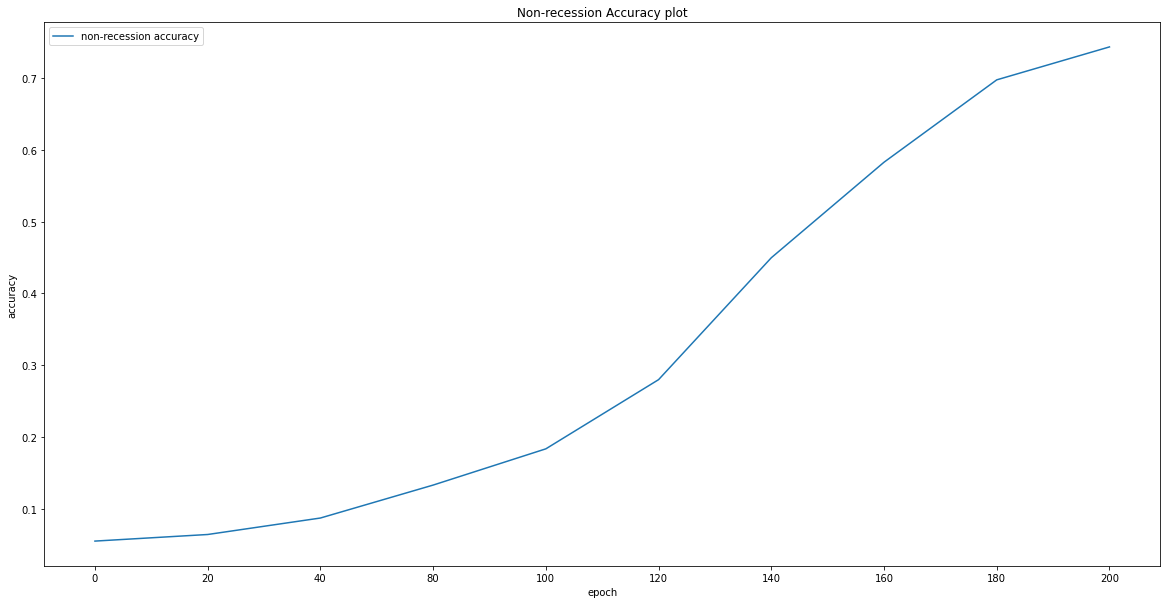

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

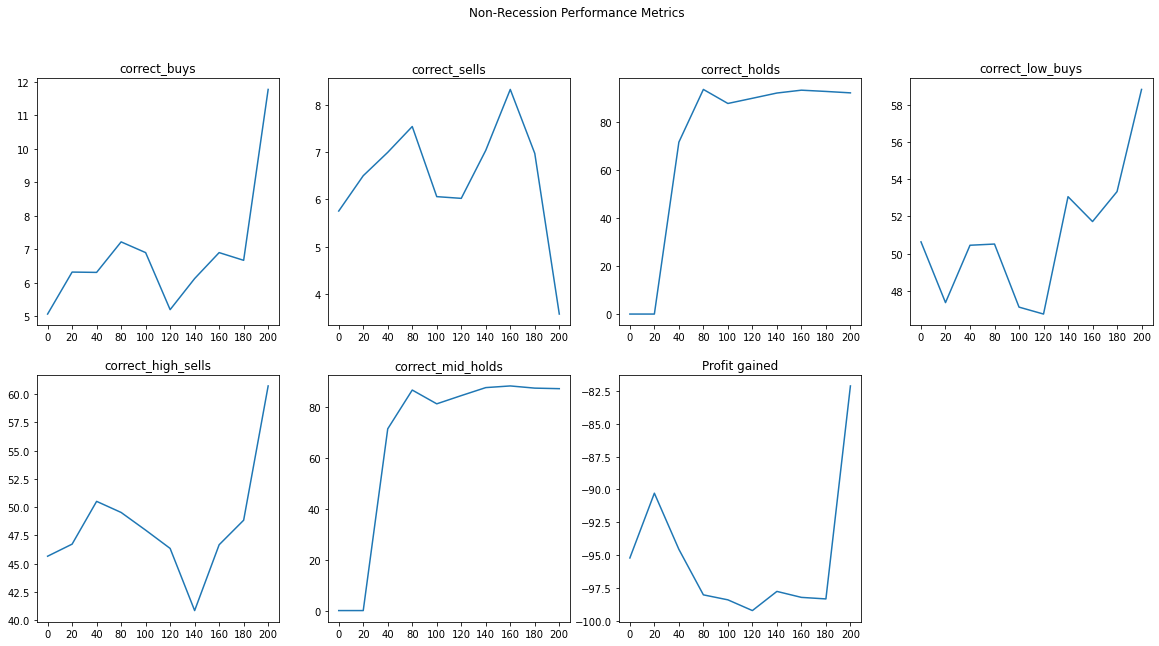

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

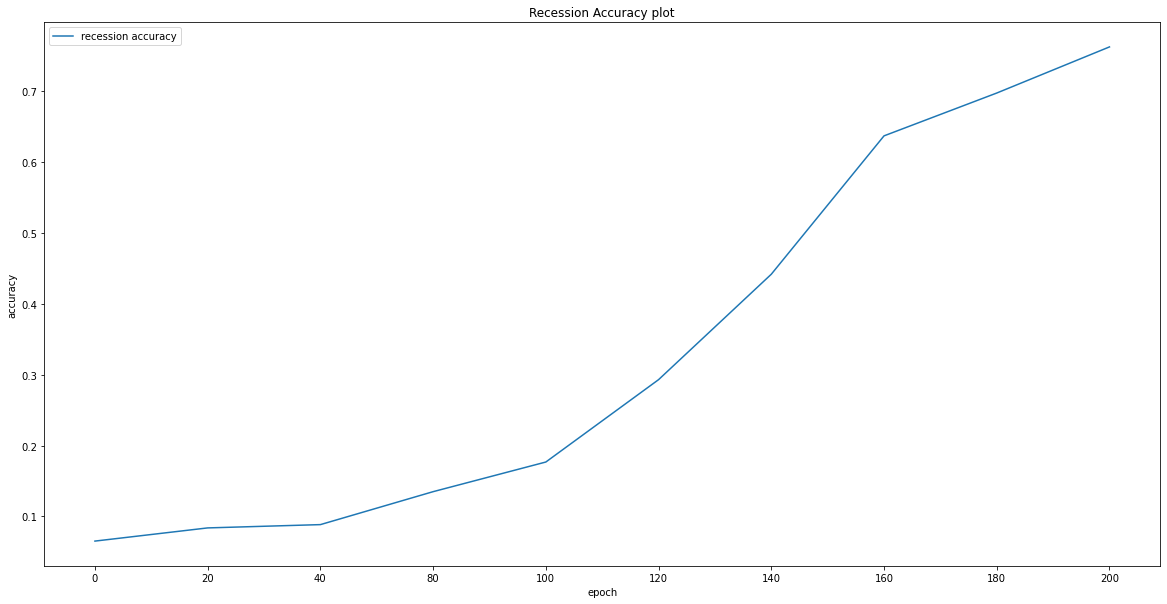

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

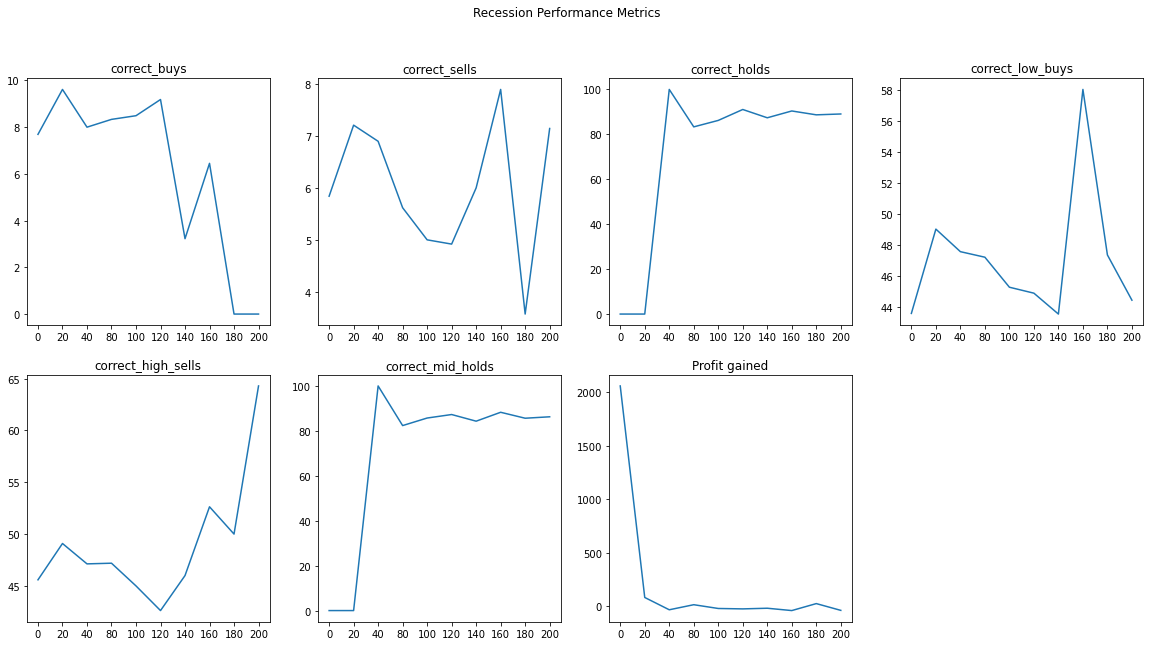

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### CNOOC Limited

In [84]:
nr_test_sets = ['0883.HK']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-12        12.74  13.032944 -77.906974  9.460210e+09     2.0
2018-12-13        12.74  12.987876 -77.906974  9.460210e+09     2.0
2018-12-14        13.06  12.998972 -59.302288  9.506982e+09     2.0
2018-12-17        12.80  12.968361 -78.048748  9.447852e+09     2.0
2018-12-18        12.68  12.923998 -95.890382  9.410332e+09     2.0


In [85]:
r_test_sets = ['0883.HK']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-12-12        11.36  11.447620 -75.000025 -214227973.0     2.0
2019-12-13        11.46  11.449525 -64.583319 -167306085.0     2.0
2019-12-16        11.78  11.500367 -31.250019  -82839244.0     2.0
2019-12-17        11.74  11.537234 -31.111168 -127828316.0     2.0
2019-12-18        12.06  11.617659  -5.999947  -67007162.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


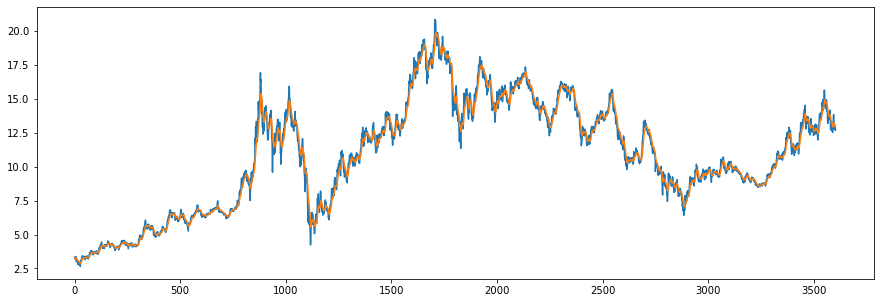

(3585, 64, 64, 1)

In [86]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/0883.HK_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

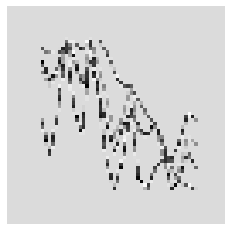

In [87]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [88]:
X = X/255

In [89]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [90]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [91]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [92]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [93]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('0883.HK')]
    y = nr_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('0883.HK'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('0883.HK')]
    y = r_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.242424242424242, 1: 7.3538461538461535, 2: 0.3668457405986186}



RUNNING EPOCHS 0 - 20



Epoch 1/20
23/23 [==============================] - 1s 27ms/step - loss: 0.2628 - accuracy: 0.4114 - mse: 1.7794 - weighted_accuracy: 0.3366 - weighted_mse: 1.9199 - val_loss: 0.2012 - val_accuracy: 0.1325 - val_mse: 0.9979 - val_weighted_accuracy: 0.1325 - val_weighted_mse: 0.9979
Epoch 2/20
23/23 [==============================] - 0s 14ms/step - loss: 0.2060 - accuracy: 0.2681 - mse: 1.1725 - weighted_accuracy: 0.3645 - weighted_mse: 1.1695 - val_loss: 0.2038 - val_accuracy: 0.0460 - val_mse: 0.9623 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 0.9623
Epoch 3/20
23/23 [==============================] - 0s 15ms/step - loss: 0.2092 - accuracy: 0.2622 - mse: 1.1595 - weighted_accuracy: 0.3238 - weighted_mse: 1.1405 - val_loss: 0.2051 - val_accuracy: 0.0460 - val_mse: 0.9448 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 0.9448
Epoch 4/20
23/23 [==============================] - 0s

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 211
actual predicted buys: 0
actual buys but predicted sell: 8
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 14
actual holds but predicted sell: 180
actual predicted holds: 0
Percentage buys correct: 0.0%
Percentage sells correct: 4.081632653061225%
Percentage holds correct: 0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 26.666666666666668%
Percentage high sells correct: 41.53846153846154%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.6978049722248196
Shares owned at the moment: 142
Cash capital at the moment: $0.6392011024218078


Price increase from previously bought: 8.788568925888018%
Share price: $0.7612196562958087
Shares owned at the moment: 0
Cash capital at the moment: $108.43513602064313


Share price: $0.8587805297869677
Shares owned at the moment: 125
Cash capital at the moment: $0.792

<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 213
actual predicted buys: 0
actual buys but predicted sell: 10
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 12
actual holds but predicted sell: 181
actual predicted holds: 0
Percentage buys correct: 0.0%
Percentage sells correct: 4.975124378109452%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 33.333333333333336%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.8147138322832077
Shares owned at the moment: 122
Cash capital at the moment: $0.3315759707176369


Price increase from previously bought: -2.747089269075753%
Share price: $0.7945118315419428
Shares owned at the moment: 0
Cash capital at the moment: $96.99546069935234


Share price: $0.7204376682727409
Shares owned at the moment: 134
Cash capital at the moment: $0.191331870046

Epoch 20/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1934 - accuracy: 0.2455 - mse: 1.2194 - weighted_accuracy: 0.4333 - weighted_mse: 1.2203 - val_loss: 0.1961 - val_accuracy: 0.0586 - val_mse: 0.9871 - val_weighted_accuracy: 0.0586 - val_weighted_mse: 0.9871
Validation loss: 0.19608770310878754
Validation accuracy: 0.05857740715146065


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.1969 - accuracy: 0.0521 - mse: 0.9856 - weighted_accuracy: 0.0521 - weighted_mse: 0.9856
Test loss: 0.19692043960094452
Test accuracy: 0.05213269963860512


number of predictions: 211
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 3
actual sells but predicted hold: 0
actual holds but predicted buy: 158
actual holds but predicted sell: 36
actual predicted holds: 0
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 7.692307692307

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 13ms/step - loss: 0.1968 - accuracy: 0.0469 - mse: 0.9795 - weighted_accuracy: 0.0469 - weighted_mse: 0.9795
Test loss: 0.1967964917421341
Test accuracy: 0.04694835841655731




<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 213
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 9
actual predicted sells: 1
actual sells but predicted hold: 0
actual holds but predicted buy: 158
actual holds but predicted sell: 35
actual predicted holds: 0
Percentage buys correct: 5.113636363636363%
Percentage sells correct: 2.7027027027027026%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 40.57142857142857%
Percentage high sells correct: 54.054054054054056%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -76.23962724766164%
Share price: $0.24063970915181354
Shares owned at the moment: 0
Cash capital at the moment: $24.265644095261315


Share price: $0.20696970791637193
Shares owned at the moment: 116
Cash capital at the moment: $

23/23 [==============================] - 0s 18ms/step - loss: 0.1877 - accuracy: 0.2165 - mse: 1.2325 - weighted_accuracy: 0.4856 - weighted_mse: 1.2155 - val_loss: 0.1967 - val_accuracy: 0.0697 - val_mse: 1.0196 - val_weighted_accuracy: 0.0697 - val_weighted_mse: 1.0196
Epoch 10/20
23/23 [==============================] - 0s 20ms/step - loss: 0.1900 - accuracy: 0.2287 - mse: 1.2471 - weighted_accuracy: 0.4366 - weighted_mse: 1.2135 - val_loss: 0.1971 - val_accuracy: 0.0600 - val_mse: 0.9627 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 0.9627
Epoch 11/20
23/23 [==============================] - 0s 18ms/step - loss: 0.1886 - accuracy: 0.2242 - mse: 1.2338 - weighted_accuracy: 0.4497 - weighted_mse: 1.1987 - val_loss: 0.1974 - val_accuracy: 0.0711 - val_mse: 1.0108 - val_weighted_accuracy: 0.0711 - val_weighted_mse: 1.0108
Epoch 12/20
23/23 [==============================] - 0s 19ms/step - loss: 0.1891 - accuracy: 0.2162 - mse: 1.2579 - weighted_accuracy: 0.4685 - weighted_mse: 1.

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 4
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 101
actual holds but predicted sell: 93
actual predicted holds: 0
Percentage buys correct: 3.669724770642202%
Percentage sells correct: 4.901960784313726%
Percentage holds correct: 0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 51.37614678899082%
Percentage high sells correct: 53.46534653465346%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.6246342008047152
Shares owned at the moment: 159
Cash capital at the moment: $0.4100407677484128


Price increase from previously bought: 8.29259860948044%
Share price: $0.6782927975265876
Shares owned at the moment: 0
Cash capital at the moment: $107.96201204875733


Share price: $0.6782927975265876
Shares owned at the moment: 158
Cash capital at the mo

<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 99
actual holds but predicted sell: 93
actual predicted holds: 1
Percentage buys correct: 6.422018348623853%
Percentage sells correct: 6.796116504854369%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 41.28440366972477%
Percentage high sells correct: 48.03921568627451%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase from previously bought: -79.11949186337114%
Share price: $0.20865316784033627
Shares owned at the moment: 0
Cash capital at the moment: $20.88069091243109


Share price: $0.4376093367925702
Shares owned at the moment: 47
Cash capita

23/23 [==============================] - 0s 16ms/step - loss: 0.1796 - accuracy: 0.2026 - mse: 1.2922 - weighted_accuracy: 0.5236 - weighted_mse: 1.2385 - val_loss: 0.1991 - val_accuracy: 0.1213 - val_mse: 1.0441 - val_weighted_accuracy: 0.1213 - val_weighted_mse: 1.0441
Epoch 9/20
23/23 [==============================] - 0s 18ms/step - loss: 0.1760 - accuracy: 0.1872 - mse: 1.2887 - weighted_accuracy: 0.5181 - weighted_mse: 1.2163 - val_loss: 0.1974 - val_accuracy: 0.1437 - val_mse: 1.0987 - val_weighted_accuracy: 0.1437 - val_weighted_mse: 1.0987
Epoch 10/20
23/23 [==============================] - 0s 19ms/step - loss: 0.1768 - accuracy: 0.1764 - mse: 1.2755 - weighted_accuracy: 0.5283 - weighted_mse: 1.2400 - val_loss: 0.1963 - val_accuracy: 0.1534 - val_mse: 1.1379 - val_weighted_accuracy: 0.1534 - val_weighted_mse: 1.1379
Epoch 11/20
23/23 [==============================] - 0s 17ms/step - loss: 0.1723 - accuracy: 0.1757 - mse: 1.3075 - weighted_accuracy: 0.5404 - weighted_mse: 1.2

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 4
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 83
actual holds but predicted sell: 88
actual predicted holds: 23
Percentage buys correct: 3.409090909090909%
Percentage sells correct: 6.122448979591836%
Percentage holds correct: 92.0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 53.608247422680414%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $0.6441463755029468
Shares owned at the moment: 154
Cash capital at the moment: $0.5286621825206907


Price increase from previously bought: 17.850859998140113%
Share price: $0.7612196562958087
Shares owned at the moment: 0
Cash capital at the moment: $117.43411272763394


Share price: $0.9807317379526521
Shares owned at the moment: 119
Cash capital 

<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 80
actual holds but predicted sell: 89
actual predicted holds: 24
Percentage buys correct: 7.954545454545454%
Percentage sells correct: 7.070707070707071%
Percentage holds correct: 92.3076923076923%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 48.97959183673469%
Percentage mid holds correct: 80.76923076923077%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase from previously bought: -79.11949186337114%
Share price: $0.20865316784033627
Shares owned at the moment: 0
Cash capital at the moment: $20.88069091243109


Share price: $0.3450168735329129
Shares owned at th

23/23 [==============================] - 0s 16ms/step - loss: 0.1596 - accuracy: 0.2089 - mse: 1.4447 - weighted_accuracy: 0.5744 - weighted_mse: 1.4440 - val_loss: 0.1979 - val_accuracy: 0.2050 - val_mse: 1.1228 - val_weighted_accuracy: 0.2050 - val_weighted_mse: 1.1228
Epoch 12/20
23/23 [==============================] - 0s 18ms/step - loss: 0.1608 - accuracy: 0.1925 - mse: 1.3619 - weighted_accuracy: 0.5683 - weighted_mse: 1.3636 - val_loss: 0.1963 - val_accuracy: 0.2273 - val_mse: 1.1610 - val_weighted_accuracy: 0.2273 - val_weighted_mse: 1.1610
Epoch 13/20
23/23 [==============================] - 0s 16ms/step - loss: 0.1595 - accuracy: 0.1939 - mse: 1.3553 - weighted_accuracy: 0.5738 - weighted_mse: 1.3172 - val_loss: 0.1968 - val_accuracy: 0.2204 - val_mse: 1.1830 - val_weighted_accuracy: 0.2204 - val_weighted_mse: 1.1830
Epoch 14/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1607 - accuracy: 0.1939 - mse: 1.3708 - weighted_accuracy: 0.5639 - weighted_mse: 1.

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 69
actual holds but predicted sell: 87
actual predicted holds: 38
Percentage buys correct: 4.109589041095891%
Percentage sells correct: 6.315789473684211%
Percentage holds correct: 88.37209302325581%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 53.42465753424658%
Percentage high sells correct: 54.255319148936174%
Percentage mid holds correct: 79.06976744186046%


Capital: 100
Share price: $0.6441463755029468
Shares owned at the moment: 154
Cash capital at the moment: $0.5286621825206907


Price increase from previously bought: 17.850859998140113%
Share price: $0.7612196562958087
Shares owned at the moment: 0
Cash capital at the moment: $117.43411272763394


Share price: $0.9173170538816635
Shares owned at the

<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 86
actual predicted holds: 30
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 8.24742268041237%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 46.42857142857143%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase from previously bought: -79.11949186337114%
Share price: $0.20865316784033627
Shares owned at the moment: 0
Cash capital at the moment: $20.88069091243109


Share price: $0.33996625293417404
Shares owned at the moment: 61
Cash capital at the mo

23/23 [==============================] - 0s 19ms/step - loss: 0.1497 - accuracy: 0.2406 - mse: 1.4587 - weighted_accuracy: 0.6416 - weighted_mse: 1.4803 - val_loss: 0.1941 - val_accuracy: 0.2692 - val_mse: 1.3085 - val_weighted_accuracy: 0.2692 - val_weighted_mse: 1.3085
Epoch 11/20
23/23 [==============================] - 0s 17ms/step - loss: 0.1484 - accuracy: 0.2472 - mse: 1.4997 - weighted_accuracy: 0.6344 - weighted_mse: 1.5261 - val_loss: 0.1939 - val_accuracy: 0.2887 - val_mse: 1.3103 - val_weighted_accuracy: 0.2887 - val_weighted_mse: 1.3103
Epoch 12/20
23/23 [==============================] - 0s 17ms/step - loss: 0.1466 - accuracy: 0.2430 - mse: 1.4932 - weighted_accuracy: 0.6497 - weighted_mse: 1.5424 - val_loss: 0.1945 - val_accuracy: 0.2734 - val_mse: 1.2912 - val_weighted_accuracy: 0.2734 - val_weighted_mse: 1.2912
Epoch 13/20
23/23 [==============================] - 0s 18ms/step - loss: 0.1446 - accuracy: 0.2416 - mse: 1.5171 - weighted_accuracy: 0.6444 - weighted_mse: 1.

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 54
actual holds but predicted sell: 86
actual predicted holds: 54
Percentage buys correct: 5.172413793103448%
Percentage sells correct: 6.382978723404255%
Percentage holds correct: 91.52542372881356%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.763440860215056%
Percentage mid holds correct: 84.7457627118644%


Capital: 100
Share price: $0.6441463755029468
Shares owned at the moment: 154
Cash capital at the moment: $0.5286621825206907


Price increase from previously bought: 17.850859998140113%
Share price: $0.7612196562958087
Shares owned at the moment: 0
Cash capital at the moment: $117.43411272763394


Share price: $0.8587805297869677
Shares owned at the moment: 136
C

<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 213
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 60
actual holds but predicted sell: 84
actual predicted holds: 49
Percentage buys correct: 6.25%
Percentage sells correct: 7.446808510638298%
Percentage holds correct: 89.0909090909091%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 40.625%
Percentage high sells correct: 50.53763440860215%
Percentage mid holds correct: 76.36363636363636%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase from previously bought: -15.436801790611243%
Share price: $0.8450167531194901
Shares owned at the moment: 0
Cash capital at the moment: $84.34204945439471


Share price: $0.8147138322832077
Shares owned at the moment: 103
Cash capit

23/23 [==============================] - 0s 19ms/step - loss: 0.1405 - accuracy: 0.3079 - mse: 1.6590 - weighted_accuracy: 0.6833 - weighted_mse: 1.7793 - val_loss: 0.1860 - val_accuracy: 0.3724 - val_mse: 1.4089 - val_weighted_accuracy: 0.3724 - val_weighted_mse: 1.4089
Epoch 12/20
23/23 [==============================] - 0s 18ms/step - loss: 0.1397 - accuracy: 0.3264 - mse: 1.6298 - weighted_accuracy: 0.6828 - weighted_mse: 1.7504 - val_loss: 0.1886 - val_accuracy: 0.3473 - val_mse: 1.3871 - val_weighted_accuracy: 0.3473 - val_weighted_mse: 1.3871
Epoch 13/20
23/23 [==============================] - 0s 18ms/step - loss: 0.1436 - accuracy: 0.2911 - mse: 1.5492 - weighted_accuracy: 0.6651 - weighted_mse: 1.6474 - val_loss: 0.1843 - val_accuracy: 0.3947 - val_mse: 1.4801 - val_weighted_accuracy: 0.3947 - val_weighted_mse: 1.4801
Epoch 14/20
23/23 [==============================] - 0s 19ms/step - loss: 0.1328 - accuracy: 0.3372 - mse: 1.7211 - weighted_accuracy: 0.7015 - weighted_mse: 1.

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 52
actual holds but predicted sell: 58
actual predicted holds: 83
Percentage buys correct: 5.454545454545454%
Percentage sells correct: 6.153846153846154%
Percentage holds correct: 89.24731182795699%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 41.81818181818182%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 79.56989247311827%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Price increase from previously bought: -78.16021402727058%
Share price: $0.20865316784033627
Shares owned at the moment: 0
Cash capital at the moment: $22.280629594042214


Share price: $0.33996625293417404
Shares owned at the moment: 6

<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
23/23 [==============================] - 1s 36ms/step - loss: 0.1339 - accuracy: 0.3543 - mse: 1.7507 - weighted_accuracy: 0.7051 - weighted_mse: 1.9190 - val_loss: 0.1814 - val_accuracy: 0.4226 - val_mse: 1.4871 - val_weighted_accuracy: 0.4226 - val_weighted_mse: 1.4871
Epoch 2/20
23/23 [==============================] - 1s 23ms/step - loss: 0.1347 - accuracy: 0.3389 - mse: 1.7418 - weighted_accuracy: 0.6874 - weighted_mse: 1.9212 - val_loss: 0.1811 - val_accuracy: 0.4254 - val_mse: 1.4990 - val_weighted_accuracy: 0.4254 - val_weighted_mse: 1.4990
Epoch 3/20
23/23 [==============================] - 0s 19ms/step - loss: 0.1335 - accuracy: 0.3766 - mse: 1.7357 - weighted_accuracy: 0.7134 - weighted_mse: 1.9598 - val_loss: 0.1785 - val_accuracy: 0.4616 - val_mse: 1.5678 - val_weighted_accuracy: 0.4616 - val_weighted_mse: 1.5678
Epoch 4/20
23/23 [==============================] - 0s 20ms/step - loss: 0.1307 - accuracy: 0.3713 - mse: 1.7584 - weighted_accuracy: 0.7306 - weighted

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 34
actual holds but predicted sell: 59
actual predicted holds: 101
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 94.39252336448598%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 47.36842105263158%
Percentage high sells correct: 52.30769230769231%
Percentage mid holds correct: 84.11214953271028%


Capital: 100
Share price: $0.6441463755029468
Shares owned at the moment: 154
Cash capital at the moment: $0.5286621825206907


Price increase from previously bought: 17.850859998140113%
Share price: $0.7612196562958087
Shares owned at the moment: 0
Cash capital at the moment: $117.43411272763394


Share price: $0.7124389869467589
Shares owned at the

<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 3
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 42
actual holds but predicted sell: 59
actual predicted holds: 92
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 89.32038834951456%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 38.63636363636363%
Percentage high sells correct: 47.69230769230769%
Percentage mid holds correct: 78.64077669902913%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Price increase from previously bought: -11.551857934779298%
Share price: $0.8450167531194901
Shares owned at the moment: 0
Cash capital at the moment: $88.28044247768437


Share price: $0.7305387489189883
Shares owned at t

23/23 [==============================] - 0s 15ms/step - loss: 0.1201 - accuracy: 0.4962 - mse: 2.0883 - weighted_accuracy: 0.7670 - weighted_mse: 2.6135 - val_loss: 0.1719 - val_accuracy: 0.4826 - val_mse: 1.6816 - val_weighted_accuracy: 0.4826 - val_weighted_mse: 1.6816
Epoch 14/20
23/23 [==============================] - 0s 14ms/step - loss: 0.1199 - accuracy: 0.4976 - mse: 1.9903 - weighted_accuracy: 0.7747 - weighted_mse: 2.5241 - val_loss: 0.1633 - val_accuracy: 0.5718 - val_mse: 1.6937 - val_weighted_accuracy: 0.5718 - val_weighted_mse: 1.6937
Epoch 15/20
23/23 [==============================] - 0s 13ms/step - loss: 0.1237 - accuracy: 0.4780 - mse: 2.0253 - weighted_accuracy: 0.7651 - weighted_mse: 2.4500 - val_loss: 0.1607 - val_accuracy: 0.5802 - val_mse: 1.6640 - val_weighted_accuracy: 0.5802 - val_weighted_mse: 1.6640
Epoch 16/20
23/23 [==============================] - 0s 13ms/step - loss: 0.1176 - accuracy: 0.4997 - mse: 2.1323 - weighted_accuracy: 0.7707 - weighted_mse: 2.

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 10ms/step - loss: 0.1687 - accuracy: 0.5493 - mse: 1.7383 - weighted_accuracy: 0.5493 - weighted_mse: 1.7383
Test loss: 0.16874854266643524
Test accuracy: 0.5492957830429077




<ipython-input-93-033e442475f1>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 3
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 35
actual holds but predicted sell: 47
actual predicted holds: 111
Percentage buys correct: 5.405405405405405%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 90.98360655737704%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 35.13513513513514%
Percentage high sells correct: 48.148148148148145%
Percentage mid holds correct: 80.99173553719008%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Price increase from previously bought: -11.551857934779298%
Share price: $0.8450167531194901
Shares owned at the moment: 0
Cash capital at the moment: $88.28044247768437


Share price: $0.7305387489189883
Shares owned at 

23/23 [==============================] - 0s 15ms/step - loss: 0.1093 - accuracy: 0.5851 - mse: 2.3594 - weighted_accuracy: 0.8141 - weighted_mse: 3.1150 - val_loss: 0.1477 - val_accuracy: 0.6597 - val_mse: 1.8519 - val_weighted_accuracy: 0.6597 - val_weighted_mse: 1.8519
Epoch 15/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1098 - accuracy: 0.5917 - mse: 2.3602 - weighted_accuracy: 0.8069 - weighted_mse: 3.1612 - val_loss: 0.1425 - val_accuracy: 0.6764 - val_mse: 1.9615 - val_weighted_accuracy: 0.6764 - val_weighted_mse: 1.9615
Epoch 16/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1064 - accuracy: 0.5812 - mse: 2.4485 - weighted_accuracy: 0.8247 - weighted_mse: 3.2139 - val_loss: 0.1444 - val_accuracy: 0.6681 - val_mse: 1.9948 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 1.9948
Epoch 17/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1089 - accuracy: 0.6032 - mse: 2.4179 - weighted_accuracy: 0.8424 - weighted_mse: 3.

<ipython-input-93-033e442475f1>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-93-033e442475f1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-93-033e442475f1>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

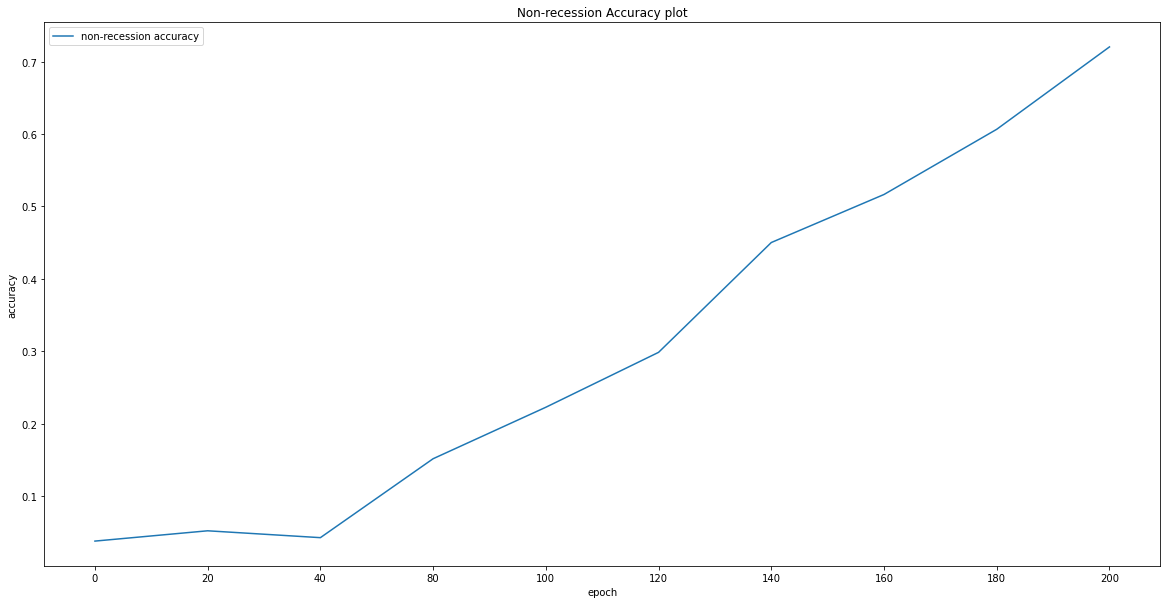

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

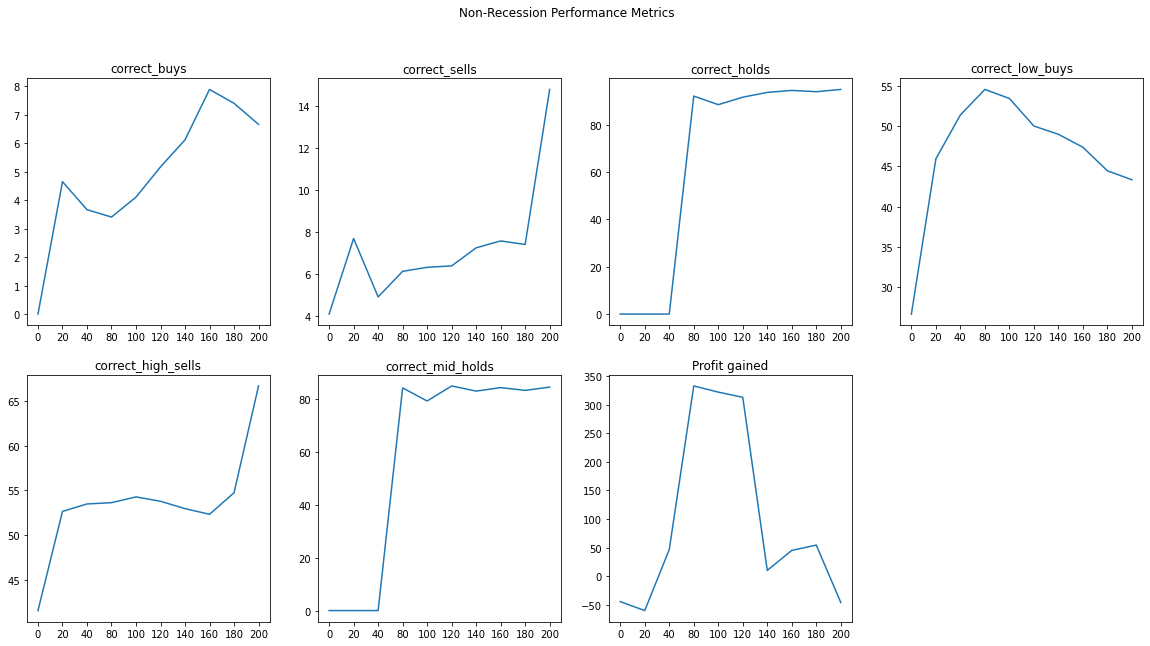

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

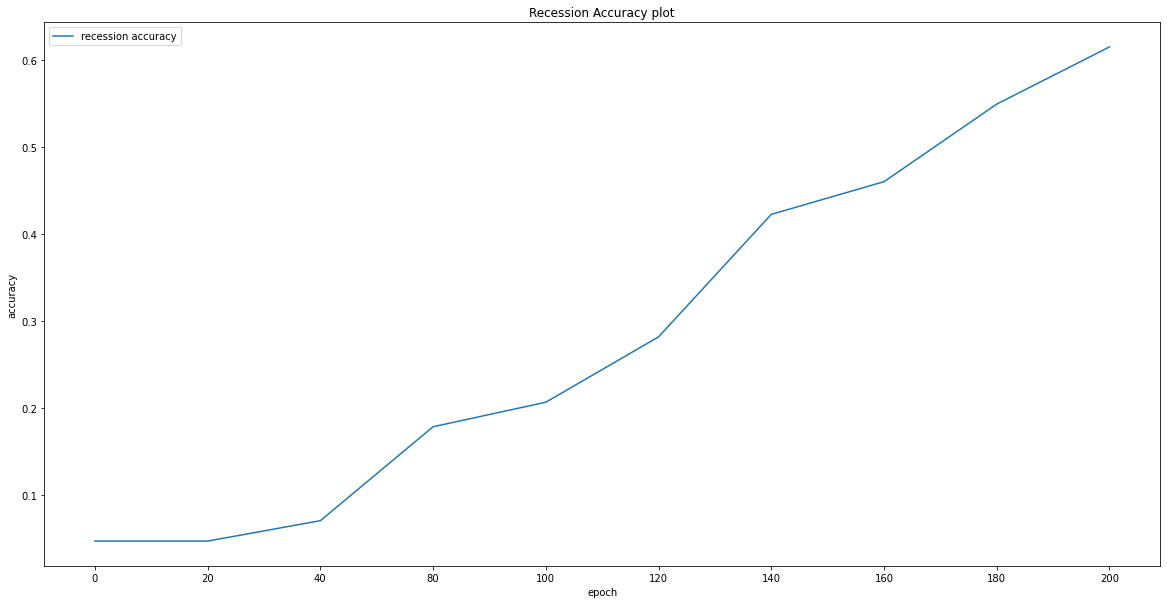

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

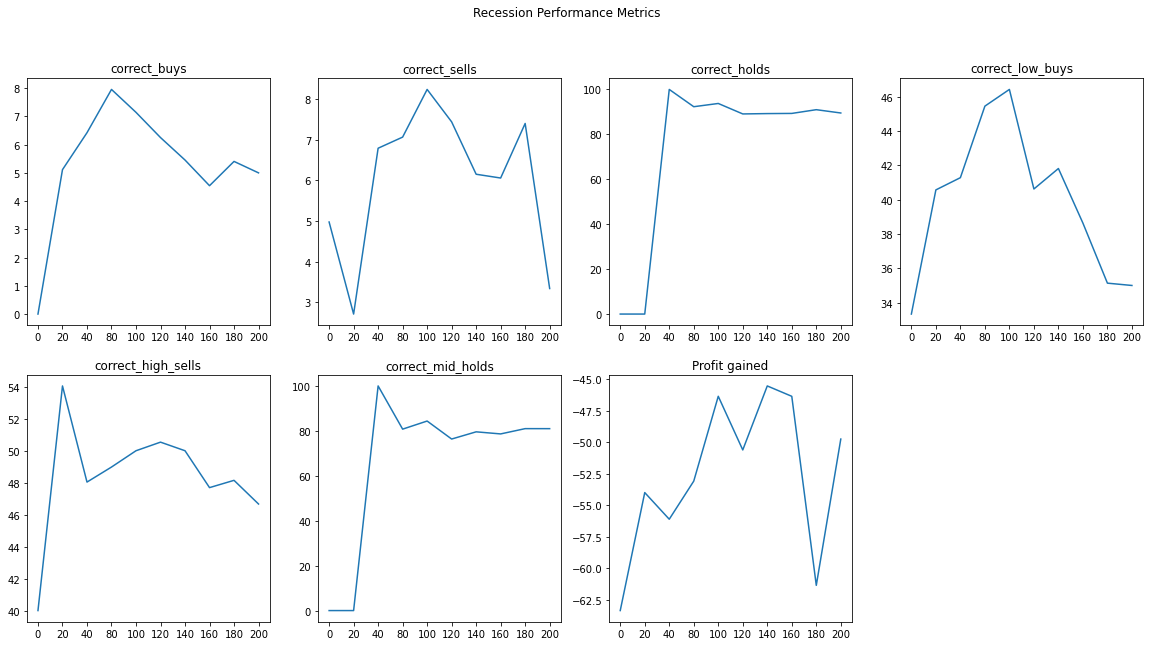

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### JP Morgan

In [56]:
nr_test_sets = ['JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-13   101.019997  105.247250 -87.215299 -1.989079e+09     2.0
2018-12-14   101.120003  104.612289 -86.480500 -1.971828e+09     2.0
2018-12-17   100.290001  103.947322 -92.578971 -1.991708e+09     2.0
2018-12-18    99.010002  103.187734 -96.055365 -2.016821e+09     2.0
2018-12-19    98.540001  102.472698 -97.156410 -2.037658e+09     2.0


In [57]:
r_test_sets = ['JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-13   138.020004  133.597310  -4.554623  284280700.0     2.0
2019-12-16   136.809998  134.091570 -19.726594  273688600.0     2.0
2019-12-17   137.339996  134.591328 -14.634146  285060600.0     2.0
2019-12-18   138.179993  135.143430  -6.439060  296607400.0     2.0
2019-12-19   138.039993  135.589055  -9.396071  286225900.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


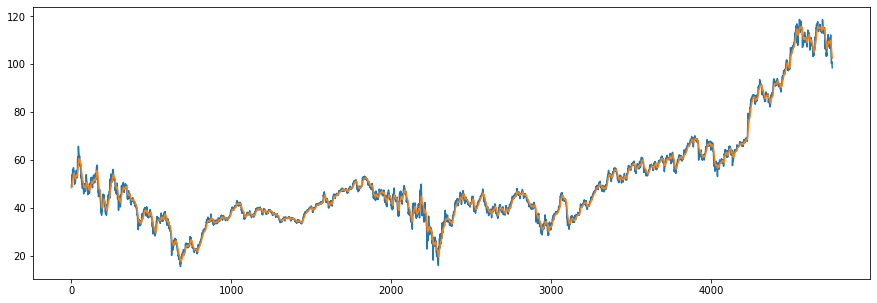

(4740, 64, 64, 1)

In [58]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

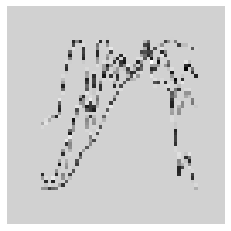

In [59]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [60]:
X = X/255

In [61]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [62]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [63]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [65]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JPM')]
    y = nr_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('JPM'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JPM')]
    y = r_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[0 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.7073170731707314, 1: 7.391812865497076, 2: 0.3656349435927104}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2542 - accuracy: 0.2890 - mse: 1.6772 - weighted_accuracy: 0.3226 - weighted_mse: 1.7715 - val_loss: 0.1996 - val_accuracy: 0.0485 - val_mse: 1.1775 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 1.1775
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2068 - accuracy: 0.4014 - mse: 1.1793 - weighted_accuracy: 0.3344 - weighted_mse: 1.2031 - val_loss: 0.1995 - val_accuracy: 0.4905 - val_mse: 0.8384 - val_weighted_accuracy: 0.4905 - val_weighted_mse: 0.8384
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2019 - accuracy: 0.3945 - mse: 1.1751 - weighted_accuracy: 0.3732 - weighted_mse: 1.1876 - val_loss: 0.1983 - val_accuracy: 0.0506 - val_mse: 1.0671 - val_weighted_accuracy: 0.0506 - val_weighted_mse: 1.0671
Epoch 4/20
30/30 [==============================] - 1s

<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 16ms/step - loss: 0.1910 - accuracy: 0.3881 - mse: 0.9858 - weighted_accuracy: 0.3881 - weighted_mse: 0.9858
Test loss: 0.19095025956630707
Test accuracy: 0.388127863407135


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 6
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 3
actual holds but predicted sell: 118
actual predicted holds: 76
Percentage buys correct: 0.0%
Percentage sells correct: 6.7669172932330826%
Percentage holds correct: 91.56626506024097%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 33.333333333333336%
Percentage high sells correct: 39.849624060150376%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.29709513235065055
Shares owned at the moment: 335
Cash capital at the moment: $0.19943177185403727


Price increase 

<ipython-input-65-efe93acc9e7b>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2016 - accuracy: 0.3695 - mse: 1.1593 - weighted_accuracy: 0.3560 - weighted_mse: 1.1800 - val_loss: 0.1888 - val_accuracy: 0.5074 - val_mse: 0.9671 - val_weighted_accuracy: 0.5074 - val_weighted_mse: 0.9671
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1988 - accuracy: 0.3420 - mse: 1.1831 - weighted_accuracy: 0.3478 - weighted_mse: 1.1770 - val_loss: 0.1963 - val_accuracy: 0.2120 - val_mse: 0.9169 - val_weighted_accuracy: 0.2120 - val_weighted_mse: 0.9169
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1986 - accuracy: 0.3499 - mse: 1.1578 - weighted_accuracy: 0.3769 - weighted_mse: 1.1748 - val_loss: 0.1992 - val_accuracy: 0.1023 - val_mse: 0.8721 - val_weighted_accuracy: 0.1023 - val_weighted_mse: 0.8721
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2001 - accuracy: 0.3708 - mse: 1.1696 - weighted_accuracy: 0.3585 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1932 - accuracy: 0.1553 - mse: 1.0339 - weighted_accuracy: 0.1553 - weighted_mse: 1.0339


<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1932007372379303
Test accuracy: 0.155251145362854


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 12
actual sells but predicted hold: 0
actual holds but predicted buy: 58
actual holds but predicted sell: 123
actual predicted holds: 16
Percentage buys correct: 9.375%
Percentage sells correct: 8.75912408759124%
Percentage holds correct: 88.88888888888889%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 48.175182481751825%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.8109157602043964
Shares owned at the moment: 122
Cash capital at the moment: $0.7962150175150668


Price increase from previously bought: -88.63490431082684%
Share price: $0.0924147958241066
Shares owned at the moment: 0
Cash capital at the moment: $12.03981494405708

<ipython-input-65-efe93acc9e7b>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 21ms/step - loss: 0.1913 - accuracy: 0.3041 - mse: 1.2125 - weighted_accuracy: 0.4325 - weighted_mse: 1.1936 - val_loss: 0.1895 - val_accuracy: 0.2553 - val_mse: 0.9990 - val_weighted_accuracy: 0.2553 - val_weighted_mse: 0.9990
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1910 - accuracy: 0.2967 - mse: 1.2017 - weighted_accuracy: 0.4196 - weighted_mse: 1.1841 - val_loss: 0.1905 - val_accuracy: 0.2384 - val_mse: 1.0231 - val_weighted_accuracy: 0.2384 - val_weighted_mse: 1.0231
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1930 - accuracy: 0.2838 - mse: 1.2081 - weighted_accuracy: 0.4185 - weighted_mse: 1.1882 - val_loss: 0.1884 - val_accuracy: 0.4568 - val_mse: 0.9649 - val_weighted_accuracy: 0.4568 - val_weighted_mse: 0.9649
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1901 - accuracy: 0.3296 - mse: 1.1814 - weighted_accuracy: 0.4371 - weighted_mse: 1.180

7/7 [==============================] - 0s 5ms/step - loss: 0.1906 - accuracy: 0.1187 - mse: 1.0879 - weighted_accuracy: 0.1187 - weighted_mse: 1.0879
Test loss: 0.19060690701007843
Test accuracy: 0.11872146278619766




<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 12
actual sells but predicted hold: 0
actual holds but predicted buy: 63
actual holds but predicted sell: 127
actual predicted holds: 7
Percentage buys correct: 10.0%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 47.5177304964539%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.8109157602043964
Shares owned at the moment: 122
Cash capital at the moment: $0.7962150175150668


Price increase from previously bought: -58.95889804740813%
Share price: $0.33372398799583336
Shares owned at the moment: 0
Cash capital at the moment: $41.39857715503413


Share price: $0.28386808871574165
Shares owned at the moment: 145
Cash capital at the momen

<ipython-input-65-efe93acc9e7b>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1788 - accuracy: 0.2447 - mse: 1.2872 - weighted_accuracy: 0.5000 - weighted_mse: 1.2482 - val_loss: 0.1901 - val_accuracy: 0.2247 - val_mse: 1.0327 - val_weighted_accuracy: 0.2247 - val_weighted_mse: 1.0327
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1797 - accuracy: 0.2307 - mse: 1.2754 - weighted_accuracy: 0.4926 - weighted_mse: 1.2225 - val_loss: 0.1876 - val_accuracy: 0.1951 - val_mse: 1.1216 - val_weighted_accuracy: 0.1951 - val_weighted_mse: 1.1216
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1764 - accuracy: 0.2534 - mse: 1.2674 - weighted_accuracy: 0.5351 - weighted_mse: 1.2354 - val_loss: 0.1926 - val_accuracy: 0.1287 - val_mse: 1.1343 - val_weighted_accuracy: 0.1287 - val_weighted_mse: 1.1343
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1796 - accuracy: 0.2321 - mse: 1.2971 - weighted_accuracy: 0.4786 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1832 - accuracy: 0.2740 - mse: 1.1451 - weighted_accuracy: 0.2740 - weighted_mse: 1.1451
Test loss: 0.18324925005435944
Test accuracy: 0.27397260069847107




<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 1
actual holds but predicted buy: 38
actual holds but predicted sell: 115
actual predicted holds: 44
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 8.59375%
Percentage holds correct: 91.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.16279069767442%
Percentage high sells correct: 46.45669291338583%
Percentage mid holds correct: 85.41666666666667%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -59.28245827325591%
Share price: $0.33372398799583336
Shares owned at the moment: 0
Cash capital at the moment: $40.610258467002794


Share price: $0.28386808871574165
Shares owned at the m

30/30 [==============================] - 0s 12ms/step - loss: 0.1613 - accuracy: 0.2416 - mse: 1.3963 - weighted_accuracy: 0.5619 - weighted_mse: 1.3534 - val_loss: 0.1881 - val_accuracy: 0.2173 - val_mse: 1.2817 - val_weighted_accuracy: 0.2173 - val_weighted_mse: 1.2817
Epoch 12/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1561 - accuracy: 0.2405 - mse: 1.4804 - weighted_accuracy: 0.5920 - weighted_mse: 1.4497 - val_loss: 0.1882 - val_accuracy: 0.2057 - val_mse: 1.1881 - val_weighted_accuracy: 0.2057 - val_weighted_mse: 1.1881
Epoch 13/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1580 - accuracy: 0.2540 - mse: 1.4113 - weighted_accuracy: 0.5930 - weighted_mse: 1.3677 - val_loss: 0.1903 - val_accuracy: 0.1698 - val_mse: 1.1826 - val_weighted_accuracy: 0.1698 - val_weighted_mse: 1.1826
Epoch 14/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1551 - accuracy: 0.2516 - mse: 1.4328 - weighted_accuracy: 0.5995 - weighted_mse: 1.



Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1806 - accuracy: 0.3607 - mse: 1.3019 - weighted_accuracy: 0.3607 - weighted_mse: 1.3019


<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1805523782968521
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 46
actual holds but predicted sell: 88
actual predicted holds: 63
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 10.891089108910892%
Percentage holds correct: 95.45454545454545%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.92307692307692%
Percentage high sells correct: 49.504950495049506%
Percentage mid holds correct: 86.15384615384616%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -59.28245827325591%
Share price: $0.33372398799583336
Shares owned at the moment: 0
Cash capital at the moment: $

30/30 [==============================] - 0s 12ms/step - loss: 0.1414 - accuracy: 0.3362 - mse: 1.5970 - weighted_accuracy: 0.6660 - weighted_mse: 1.6032 - val_loss: 0.1892 - val_accuracy: 0.2859 - val_mse: 1.4686 - val_weighted_accuracy: 0.2859 - val_weighted_mse: 1.4686
Epoch 11/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1399 - accuracy: 0.3505 - mse: 1.6465 - weighted_accuracy: 0.6595 - weighted_mse: 1.6674 - val_loss: 0.1846 - val_accuracy: 0.3460 - val_mse: 1.4957 - val_weighted_accuracy: 0.3460 - val_weighted_mse: 1.4957
Epoch 12/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1374 - accuracy: 0.3521 - mse: 1.6902 - weighted_accuracy: 0.6676 - weighted_mse: 1.7310 - val_loss: 0.1777 - val_accuracy: 0.4167 - val_mse: 1.3778 - val_weighted_accuracy: 0.4167 - val_weighted_mse: 1.3778
Epoch 13/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1364 - accuracy: 0.3631 - mse: 1.6676 - weighted_accuracy: 0.6775 - weighted_mse: 1.

7/7 [==============================] - 0s 3ms/step - loss: 0.1742 - accuracy: 0.4703 - mse: 1.4902 - weighted_accuracy: 0.4703 - weighted_mse: 1.4902


<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.174238383769989
Test accuracy: 0.47031962871551514


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 34
actual holds but predicted sell: 71
actual predicted holds: 92
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 8.75%
Percentage holds correct: 91.08910891089108%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 47.5%
Percentage mid holds correct: 83.0%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -59.28245827325591%
Share price: $0.33372398799583336
Shares owned at the moment: 0
Cash capital at the moment: $40.610258467002794


Share price: $0.28386808871574165

30/30 [==============================] - 0s 13ms/step - loss: 0.1243 - accuracy: 0.4699 - mse: 1.8667 - weighted_accuracy: 0.7258 - weighted_mse: 2.0025 - val_loss: 0.1705 - val_accuracy: 0.5042 - val_mse: 1.6808 - val_weighted_accuracy: 0.5042 - val_weighted_mse: 1.6808
Epoch 11/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1269 - accuracy: 0.4591 - mse: 1.8765 - weighted_accuracy: 0.7198 - weighted_mse: 2.0550 - val_loss: 0.1744 - val_accuracy: 0.4800 - val_mse: 1.6837 - val_weighted_accuracy: 0.4800 - val_weighted_mse: 1.6837
Epoch 12/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1226 - accuracy: 0.4660 - mse: 1.9643 - weighted_accuracy: 0.7248 - weighted_mse: 2.1223 - val_loss: 0.1621 - val_accuracy: 0.5728 - val_mse: 1.5760 - val_weighted_accuracy: 0.5728 - val_weighted_mse: 1.5760
Epoch 13/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1200 - accuracy: 0.4892 - mse: 1.9260 - weighted_accuracy: 0.7310 - weighted_mse: 2.

7/7 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.6393 - mse: 1.6157 - weighted_accuracy: 0.6393 - weighted_mse: 1.6157
Test loss: 0.15829479694366455
Test accuracy: 0.6392694115638733




<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 20
actual holds but predicted sell: 43
actual predicted holds: 134
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 89.33333333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 59.09090909090909%
Percentage high sells correct: 53.191489361702125%
Percentage mid holds correct: 82.5503355704698%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -59.28245827325591%
Share price: $0.33372398799583336
Shares owned at the moment: 0
Cash capital at the moment: $40.610258467002794


Share price: $0.28386808871574165
Shares owned a

30/30 [==============================] - 0s 17ms/step - loss: 0.1101 - accuracy: 0.5730 - mse: 2.1479 - weighted_accuracy: 0.7557 - weighted_mse: 2.4958 - val_loss: 0.1610 - val_accuracy: 0.5770 - val_mse: 1.7428 - val_weighted_accuracy: 0.5770 - val_weighted_mse: 1.7428
Epoch 15/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1101 - accuracy: 0.5854 - mse: 2.2239 - weighted_accuracy: 0.7448 - weighted_mse: 2.5657 - val_loss: 0.1460 - val_accuracy: 0.6624 - val_mse: 1.7837 - val_weighted_accuracy: 0.6624 - val_weighted_mse: 1.7837
Epoch 16/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1072 - accuracy: 0.5849 - mse: 2.2130 - weighted_accuracy: 0.7656 - weighted_mse: 2.6222 - val_loss: 0.1514 - val_accuracy: 0.6371 - val_mse: 1.7734 - val_weighted_accuracy: 0.6371 - val_weighted_mse: 1.7734
Epoch 17/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1063 - accuracy: 0.5849 - mse: 2.2200 - weighted_accuracy: 0.7717 - weighted_mse: 2.

<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 16
actual holds but predicted sell: 25
actual predicted holds: 156
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 90.17341040462428%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 61.111111111111114%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.55813953488372%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -59.28245827325591%
Share price: $0.33372398799583336
Shares owned at the moment: 0
Cash capital at the moment: $40.610258467002794


Share price: $0.09478887394434386
Shares owned at the mome

30/30 [==============================] - 0s 13ms/step - loss: 0.1043 - accuracy: 0.6313 - mse: 2.4817 - weighted_accuracy: 0.7693 - weighted_mse: 2.9766 - val_loss: 0.1314 - val_accuracy: 0.7321 - val_mse: 1.9260 - val_weighted_accuracy: 0.7321 - val_weighted_mse: 1.9260
Epoch 19/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0954 - accuracy: 0.6406 - mse: 2.5956 - weighted_accuracy: 0.8031 - weighted_mse: 3.3351 - val_loss: 0.1248 - val_accuracy: 0.7669 - val_mse: 2.0008 - val_weighted_accuracy: 0.7669 - val_weighted_mse: 2.0008
Epoch 20/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0989 - accuracy: 0.6450 - mse: 2.5662 - weighted_accuracy: 0.7894 - weighted_mse: 3.1205 - val_loss: 0.1327 - val_accuracy: 0.7289 - val_mse: 2.0476 - val_weighted_accuracy: 0.7289 - val_weighted_mse: 2.0476
Validation loss: 0.13266621530056
Validation accuracy: 0.7289029359817505


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.14

<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.13210082054138184
Test accuracy: 0.7488584518432617


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 12
actual holds but predicted sell: 25
actual predicted holds: 160
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 89.88764044943821%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 82.48587570621469%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -49.682244318973034%
Share price: $0.41240805266598013
Shares owned at the moment: 0
Cash capital at the moment: $50.1833158

30/30 [==============================] - 0s 14ms/step - loss: 0.0911 - accuracy: 0.6780 - mse: 2.9863 - weighted_accuracy: 0.7860 - weighted_mse: 3.8476 - val_loss: 0.1136 - val_accuracy: 0.8133 - val_mse: 2.1365 - val_weighted_accuracy: 0.8133 - val_weighted_mse: 2.1365
Epoch 20/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0890 - accuracy: 0.6793 - mse: 3.0103 - weighted_accuracy: 0.7926 - weighted_mse: 4.0119 - val_loss: 0.1159 - val_accuracy: 0.7985 - val_mse: 2.1155 - val_weighted_accuracy: 0.7985 - val_weighted_mse: 2.1155
Validation loss: 0.11587454378604889
Validation accuracy: 0.7985231876373291


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1255 - accuracy: 0.7661 - mse: 2.1981 - weighted_accuracy: 0.7661 - weighted_mse: 2.1981
Test loss: 0.12547270953655243
Test accuracy: 0.7660550475120544


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual 

<ipython-input-65-efe93acc9e7b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-efe93acc9e7b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-efe93acc9e7b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

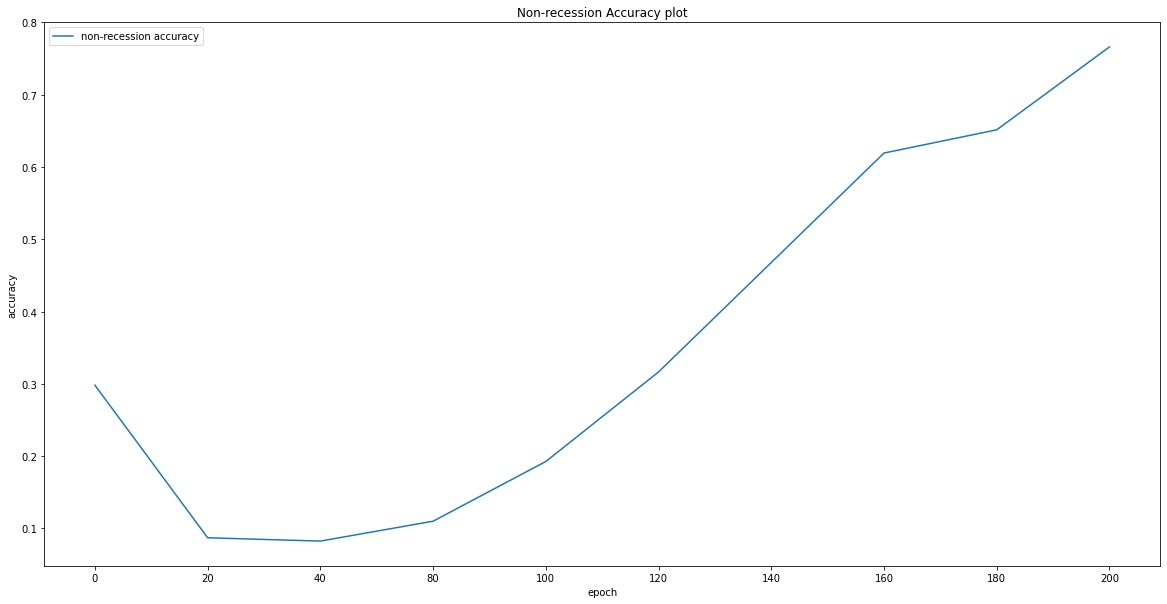

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

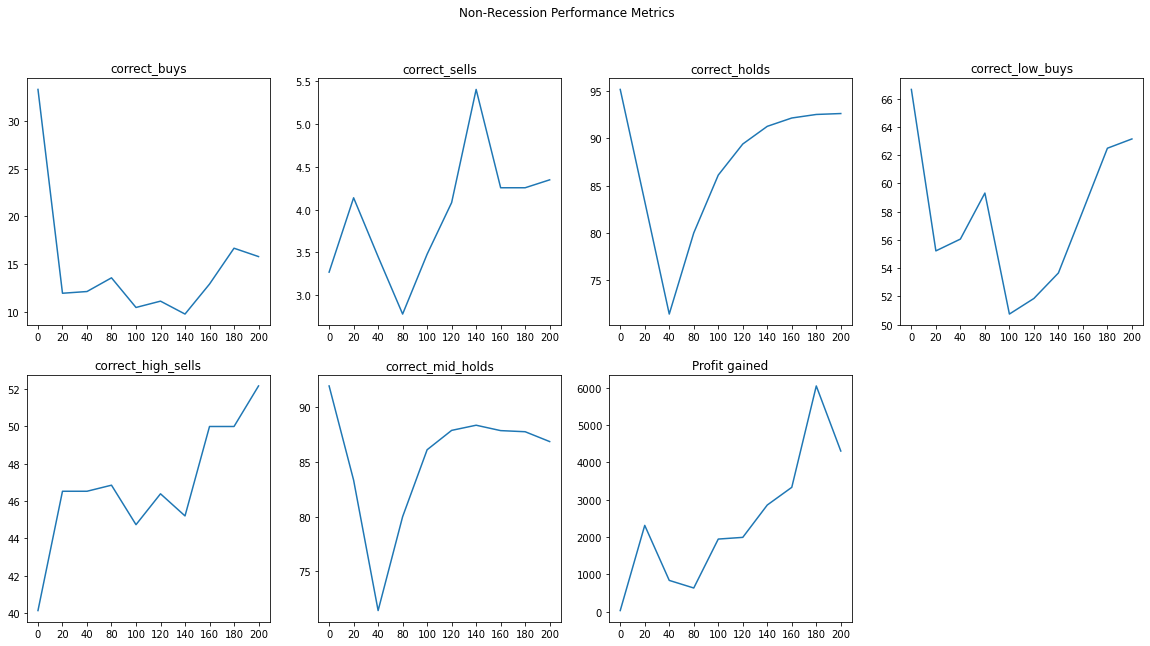

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

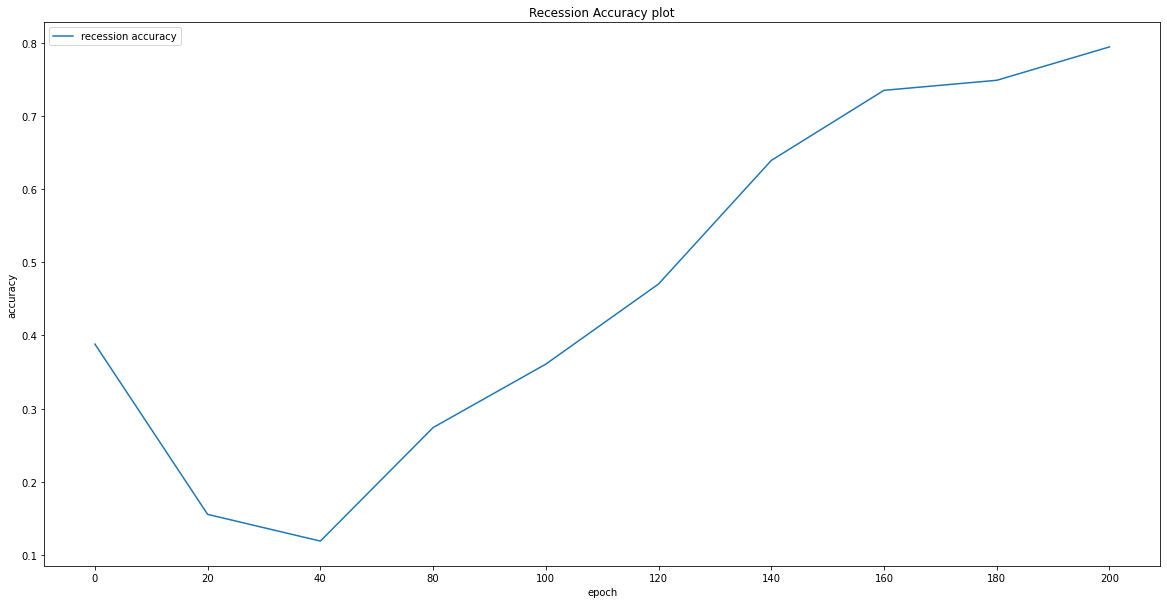

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

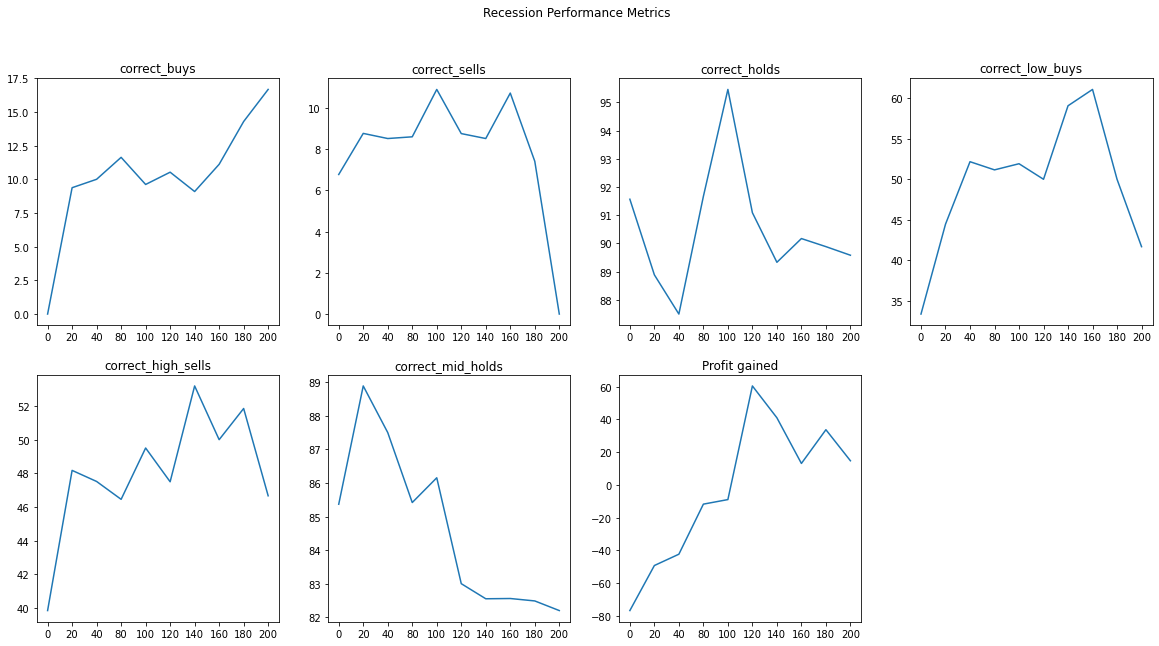

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### American Axle

In [70]:
nr_test_sets = ['AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-13        11.52  11.820811 -67.289689  230854400.0     2.0
2018-12-14        11.52  11.774532 -67.289689  230854400.0     2.0
2018-12-17        11.27  11.696912 -78.971930  229177400.0     2.0
2018-12-18        11.25  11.628156 -79.906531  227542600.0     2.0
2018-12-19        11.43  11.597671 -71.495303  229242700.0     2.0


In [71]:
r_test_sets = ['AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-12-13        11.04  10.136919  -2.162160 -8221900.0     2.0
2019-12-16        10.54  10.198932 -35.467981 -9883500.0     2.0
2019-12-17        10.67  10.271404 -29.064037 -8890800.0     2.0
2019-12-18        10.64  10.328111 -30.541856 -9882500.0     2.0
2019-12-19        10.77  10.396094 -24.137912 -8689200.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


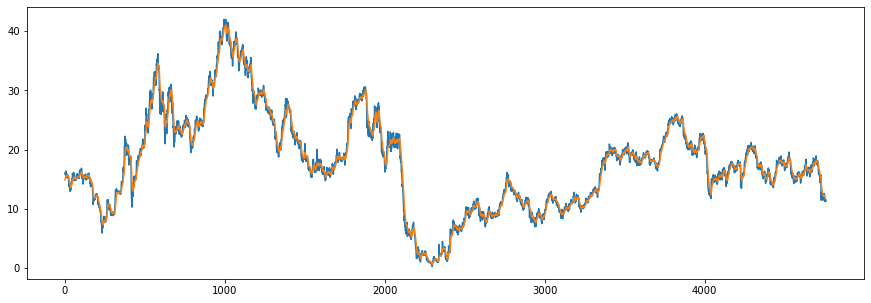

(4740, 64, 64, 1)

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/AXL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

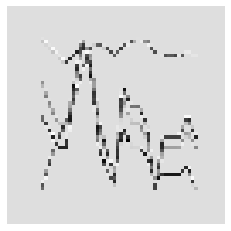

In [73]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [74]:
X = X/255

In [75]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [76]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [77]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [79]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('AXL')]
    y = nr_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('AXL'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('AXL')]
    y = r_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.264367816091954, 1: 7.30635838150289, 2: 0.3669085631349782}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.2493 - accuracy: 0.4773 - mse: 1.5588 - weighted_accuracy: 0.3395 - weighted_mse: 1.6885 - val_loss: 0.1890 - val_accuracy: 0.8850 - val_mse: 0.8168 - val_weighted_accuracy: 0.8850 - val_weighted_mse: 0.8168
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2087 - accuracy: 0.4818 - mse: 1.1359 - weighted_accuracy: 0.3375 - weighted_mse: 1.1632 - val_loss: 0.1801 - val_accuracy: 0.8945 - val_mse: 0.9283 - val_weighted_accuracy: 0.8945 - val_weighted_mse: 0.9283
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2110 - accuracy: 0.3476 - mse: 1.1733 - weighted_accuracy: 0.3175 - weighted_mse: 1.1616 - val_loss: 0.1897 - val_accuracy: 0.6593 - val_mse: 1.0470 - val_weighted_accuracy: 0.6593 - val_weighted_mse: 1.0470
Epoch 4/20
30/30 [==============================] - 0s 1

7/7 [==============================] - 0s 3ms/step - loss: 0.1953 - accuracy: 0.0731 - mse: 1.1518 - weighted_accuracy: 0.0731 - weighted_mse: 1.1518


<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.19529643654823303
Test accuracy: 0.07305935770273209


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 91
actual holds but predicted sell: 106
actual predicted holds: 0
Percentage buys correct: 7.8431372549019605%
Percentage sells correct: 6.837606837606837%
Percentage holds correct: 0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 40.59405940594059%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9942105416710021
Shares owned at the moment: 100
Cash capital at the moment: $0.30553793394025774


Price increase from previously bought: -69.43292220078557%
Share price: $0.30473683781240796
Shares owned at the moment: 0
Cash capital at the moment: $30.69541908478264


Share price: 

Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1984 - accuracy: 0.3861 - mse: 1.1930 - weighted_accuracy: 0.4044 - weighted_mse: 1.1762 - val_loss: 0.1878 - val_accuracy: 0.5000 - val_mse: 1.0432 - val_weighted_accuracy: 0.5000 - val_weighted_mse: 1.0432
Epoch 8/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1979 - accuracy: 0.4378 - mse: 1.1790 - weighted_accuracy: 0.3831 - weighted_mse: 1.1917 - val_loss: 0.1860 - val_accuracy: 0.6646 - val_mse: 0.9749 - val_weighted_accuracy: 0.6646 - val_weighted_mse: 0.9749
Epoch 9/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1950 - accuracy: 0.3811 - mse: 1.1654 - weighted_accuracy: 0.3971 - weighted_mse: 1.1684 - val_loss: 0.1888 - val_accuracy: 0.5549 - val_mse: 1.0024 - val_weighted_accuracy: 0.5549 - val_weighted_mse: 1.0024
Epoch 10/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1959 - accuracy: 0.3534 - mse: 1.2133 - weighted_accuracy: 0.4214 - weighte

7/7 [==============================] - 0s 3ms/step - loss: 0.1949 - accuracy: 0.1644 - mse: 1.0647 - weighted_accuracy: 0.1644 - weighted_mse: 1.0647
Test loss: 0.1949470341205597
Test accuracy: 0.16438356041908264


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 104
actual holds but predicted sell: 73
actual predicted holds: 20
Percentage buys correct: 8.547008547008547%
Percentage sells correct: 7.594936708860759%
Percentage holds correct: 86.95652173913044%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 46.55172413793103%
Percentage high sells correct: 54.43037974683544%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price i

<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1886 - accuracy: 0.2307 - mse: 1.2082 - weighted_accuracy: 0.4514 - weighted_mse: 1.1779 - val_loss: 0.1929 - val_accuracy: 0.1603 - val_mse: 1.1096 - val_weighted_accuracy: 0.1603 - val_weighted_mse: 1.1096
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1845 - accuracy: 0.2418 - mse: 1.2179 - weighted_accuracy: 0.4847 - weighted_mse: 1.1879 - val_loss: 0.1958 - val_accuracy: 0.1582 - val_mse: 1.0544 - val_weighted_accuracy: 0.1582 - val_weighted_mse: 1.0544
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1884 - accuracy: 0.2239 - mse: 1.2232 - weighted_accuracy: 0.4543 - weighted_mse: 1.1927 - val_loss: 0.1983 - val_accuracy: 0.1656 - val_mse: 0.9814 - val_weighted_accuracy: 0.1656 - val_weighted_mse: 0.9814
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1862 - accuracy: 0.2181 - mse: 1.2585 - weighted_accuracy: 0.4777 - weighted

0           -40.1962  


Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1954 - accuracy: 0.2146 - mse: 1.2118 - weighted_accuracy: 0.2146 - weighted_mse: 1.2118


<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.19536447525024414
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 91
actual predicted holds: 32
Percentage buys correct: 8.536585365853659%
Percentage sells correct: 8.0%
Percentage holds correct: 86.48648648648648%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.08641975308642%
Percentage high sells correct: 56.0%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price increase from previously bought: 5.006662375095994%
Share price: $0.9942105416710021
Shares owned at the moment: 0
Cash capital at the moment: $104.6902823985346


Share price: $

30/30 [==============================] - 1s 21ms/step - loss: 0.1661 - accuracy: 0.2360 - mse: 1.3717 - weighted_accuracy: 0.5611 - weighted_mse: 1.3126 - val_loss: 0.1940 - val_accuracy: 0.1857 - val_mse: 1.1806 - val_weighted_accuracy: 0.1857 - val_weighted_mse: 1.1806
Epoch 7/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1659 - accuracy: 0.2189 - mse: 1.3162 - weighted_accuracy: 0.5657 - weighted_mse: 1.2758 - val_loss: 0.1936 - val_accuracy: 0.1983 - val_mse: 1.2334 - val_weighted_accuracy: 0.1983 - val_weighted_mse: 1.2334
Epoch 8/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1693 - accuracy: 0.2252 - mse: 1.3526 - weighted_accuracy: 0.5351 - weighted_mse: 1.2903 - val_loss: 0.1949 - val_accuracy: 0.1983 - val_mse: 1.1528 - val_weighted_accuracy: 0.1983 - val_weighted_mse: 1.1528
Epoch 9/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1653 - accuracy: 0.2379 - mse: 1.3530 - weighted_accuracy: 0.5562 - weighted_mse: 1.306

7/7 [==============================] - 0s 5ms/step - loss: 0.1945 - accuracy: 0.1963 - mse: 1.2152 - weighted_accuracy: 0.1963 - weighted_mse: 1.2152
Test loss: 0.19451665878295898
Test accuracy: 0.19634702801704407




<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 79
actual holds but predicted sell: 86
actual predicted holds: 32
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 6.315789473684211%
Percentage holds correct: 82.05128205128206%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.588235294117645%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 76.3157894736842%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price increase from previously bought: 5.006662375095994%
Share price: $0.9942105416710021
Shares owned at the moment: 0
Cash capital at the moment: $104.6902823985346


Share price: $0.6915789433232307
Shares owned at the mo

<ipython-input-79-7b5800b56c32>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1572 - accuracy: 0.2703 - mse: 1.4050 - weighted_accuracy: 0.5882 - weighted_mse: 1.3682 - val_loss: 0.1945 - val_accuracy: 0.2226 - val_mse: 1.2494 - val_weighted_accuracy: 0.2226 - val_weighted_mse: 1.2494
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1578 - accuracy: 0.2619 - mse: 1.4205 - weighted_accuracy: 0.5851 - weighted_mse: 1.3768 - val_loss: 0.1961 - val_accuracy: 0.2257 - val_mse: 1.2334 - val_weighted_accuracy: 0.2257 - val_weighted_mse: 1.2334
Epoch 3/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1553 - accuracy: 0.2669 - mse: 1.4055 - weighted_accuracy: 0.5924 - weighted_mse: 1.3810 - val_loss: 0.1914 - val_accuracy: 0.2532 - val_mse: 1.3331 - val_weighted_accuracy: 0.2532 - val_weighted_mse: 1.3331
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1578 - accuracy: 0.2458 - mse: 1.4293 - weighted_accuracy: 0.5629 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1882 - accuracy: 0.2831 - mse: 1.3273 - weighted_accuracy: 0.2831 - weighted_mse: 1.3273


<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.18815623223781586
Test accuracy: 0.2831050157546997


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 76
actual holds but predicted sell: 70
actual predicted holds: 51
Percentage buys correct: 6.097560975609756%
Percentage sells correct: 7.594936708860759%
Percentage holds correct: 87.93103448275862%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 51.21951219512195%
Percentage high sells correct: 55.69620253164557%
Percentage mid holds correct: 80.70175438596492%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price increase from previously bought: 5.006662375095994%
Share price: $0.9942105416710021
Shares owned at the moment: 0
Cash capital at the moment: $104.6902

<ipython-input-79-7b5800b56c32>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1443 - accuracy: 0.3534 - mse: 1.5777 - weighted_accuracy: 0.6277 - weighted_mse: 1.5862 - val_loss: 0.1812 - val_accuracy: 0.3565 - val_mse: 1.3416 - val_weighted_accuracy: 0.3565 - val_weighted_mse: 1.3416
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1444 - accuracy: 0.3621 - mse: 1.5124 - weighted_accuracy: 0.6199 - weighted_mse: 1.5423 - val_loss: 0.1810 - val_accuracy: 0.3513 - val_mse: 1.3801 - val_weighted_accuracy: 0.3513 - val_weighted_mse: 1.3801
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1422 - accuracy: 0.3779 - mse: 1.5525 - weighted_accuracy: 0.6277 - weighted_mse: 1.6082 - val_loss: 0.1870 - val_accuracy: 0.3249 - val_mse: 1.3021 - val_weighted_accuracy: 0.3249 - val_weighted_mse: 1.3021
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1376 - accuracy: 0.3708 - mse: 1.5849 - weighted_accuracy: 0.6542 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1783 - accuracy: 0.3973 - mse: 1.3852 - weighted_accuracy: 0.3973 - weighted_mse: 1.3852
Test loss: 0.17832738161087036
Test accuracy: 0.39726027846336365




<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 61
actual holds but predicted sell: 59
actual predicted holds: 77
Percentage buys correct: 7.462686567164179%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 89.53488372093024%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.73134328358209%
Percentage high sells correct: 57.57575757575758%
Percentage mid holds correct: 81.17647058823529%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price increase from previously bought: -15.144162823150943%
Share price: $0.8034210966746227
Shares owned at the moment: 0
Cash capital at the moment: $84.71248112615746


Share price: $0.7323683459689425
Shares owned at the 

<ipython-input-79-7b5800b56c32>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1360 - accuracy: 0.4649 - mse: 1.6383 - weighted_accuracy: 0.6560 - weighted_mse: 1.7565 - val_loss: 0.1725 - val_accuracy: 0.4747 - val_mse: 1.4061 - val_weighted_accuracy: 0.4747 - val_weighted_mse: 1.4061
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1338 - accuracy: 0.4507 - mse: 1.6665 - weighted_accuracy: 0.6525 - weighted_mse: 1.8230 - val_loss: 0.1770 - val_accuracy: 0.4146 - val_mse: 1.4235 - val_weighted_accuracy: 0.4146 - val_weighted_mse: 1.4235
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1328 - accuracy: 0.4586 - mse: 1.6712 - weighted_accuracy: 0.6682 - weighted_mse: 1.8686 - val_loss: 0.1718 - val_accuracy: 0.4884 - val_mse: 1.4193 - val_weighted_accuracy: 0.4884 - val_weighted_mse: 1.4193
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1334 - accuracy: 0.4773 - mse: 1.6428 - weighted_accuracy: 0.6604 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1576 - accuracy: 0.6164 - mse: 1.5521 - weighted_accuracy: 0.6164 - weighted_mse: 1.5521
Test loss: 0.15761637687683105
Test accuracy: 0.6164383292198181




<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 42
actual holds but predicted sell: 25
actual predicted holds: 130
Percentage buys correct: 6.521739130434782%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 89.04109589041096%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 83.44827586206897%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price increase from previously bought: -78.2371057707609%
Share price: $0.20605262914357764
Shares owned at the moment: 0
Cash capital at the moment: $22.161282180397322


Share price: $0.17052631653246791
Shares owned at the moment: 129

<ipython-input-79-7b5800b56c32>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 21ms/step - loss: 0.1247 - accuracy: 0.5765 - mse: 1.7956 - weighted_accuracy: 0.6987 - weighted_mse: 2.0541 - val_loss: 0.1566 - val_accuracy: 0.6002 - val_mse: 1.4511 - val_weighted_accuracy: 0.6002 - val_weighted_mse: 1.4511
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1211 - accuracy: 0.5815 - mse: 1.7826 - weighted_accuracy: 0.7060 - weighted_mse: 2.1397 - val_loss: 0.1611 - val_accuracy: 0.5601 - val_mse: 1.5461 - val_weighted_accuracy: 0.5601 - val_weighted_mse: 1.5461
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1212 - accuracy: 0.5738 - mse: 1.7791 - weighted_accuracy: 0.6977 - weighted_mse: 2.1063 - val_loss: 0.1478 - val_accuracy: 0.6487 - val_mse: 1.5068 - val_weighted_accuracy: 0.6487 - val_weighted_mse: 1.5068
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1219 - accuracy: 0.5841 - mse: 1.8374 - weighted_accuracy: 0.7033 - weighted_mse: 2.201

7/7 [==============================] - 0s 6ms/step - loss: 0.1333 - accuracy: 0.7534 - mse: 1.7000 - weighted_accuracy: 0.7534 - weighted_mse: 1.7000
Test loss: 0.1333426684141159
Test accuracy: 0.7534246444702148




<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 22
actual holds but predicted sell: 13
actual predicted holds: 162
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 90.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 45.833333333333336%
Percentage high sells correct: 80.0%
Percentage mid holds correct: 84.91620111731844%


Capital: 100
Share price: $0.7021052488758956
Shares owned at the moment: 142
Cash capital at the moment: $0.026882559936780126


Price increase from previously bought: -70.73265885108572%
Share price: $0.20605262914357764
Shares owned at the moment: 0
Cash capital at the moment: $29.205892346644234


Share price: $0.6731579086060666
Shares owned at the moment: 43
Cash c

<ipython-input-79-7b5800b56c32>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1045 - accuracy: 0.6706 - mse: 1.9912 - weighted_accuracy: 0.7715 - weighted_mse: 2.5576 - val_loss: 0.1293 - val_accuracy: 0.7447 - val_mse: 1.6607 - val_weighted_accuracy: 0.7447 - val_weighted_mse: 1.6607
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1037 - accuracy: 0.6862 - mse: 2.0074 - weighted_accuracy: 0.7791 - weighted_mse: 2.5837 - val_loss: 0.1419 - val_accuracy: 0.6741 - val_mse: 1.6725 - val_weighted_accuracy: 0.6741 - val_weighted_mse: 1.6725
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1053 - accuracy: 0.6709 - mse: 1.9845 - weighted_accuracy: 0.7533 - weighted_mse: 2.5608 - val_loss: 0.1277 - val_accuracy: 0.7511 - val_mse: 1.6937 - val_weighted_accuracy: 0.7511 - val_weighted_mse: 1.6937
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0989 - accuracy: 0.6886 - mse: 2.0894 - weighted_accuracy: 0.7945 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1242 - accuracy: 0.7808 - mse: 1.8359 - weighted_accuracy: 0.7808 - weighted_mse: 1.8359


<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.12421493232250214
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 17
actual holds but predicted sell: 12
actual predicted holds: 168
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 89.83957219251337%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 64.28571428571429%
Percentage mid holds correct: 84.40860215053763%


Capital: 100
Share price: $0.7021052488758956
Shares owned at the moment: 142
Cash capital at the moment: $0.026882559936780126


Price increase from previously bought: -70.73265885108572%
Share price: $0.20605262914357764
Shares owned at the moment: 0
Cash capital at the moment: $29.205892346

<ipython-input-79-7b5800b56c32>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0900 - accuracy: 0.7350 - mse: 2.2467 - weighted_accuracy: 0.8078 - weighted_mse: 3.0060 - val_loss: 0.1150 - val_accuracy: 0.8017 - val_mse: 1.7857 - val_weighted_accuracy: 0.8017 - val_weighted_mse: 1.7857
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0918 - accuracy: 0.7318 - mse: 2.3077 - weighted_accuracy: 0.7867 - weighted_mse: 3.0401 - val_loss: 0.1247 - val_accuracy: 0.7521 - val_mse: 1.8050 - val_weighted_accuracy: 0.7521 - val_weighted_mse: 1.8050
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0917 - accuracy: 0.7344 - mse: 2.3599 - weighted_accuracy: 0.7912 - weighted_mse: 3.0845 - val_loss: 0.1190 - val_accuracy: 0.7679 - val_mse: 1.7901 - val_weighted_accuracy: 0.7679 - val_weighted_mse: 1.7901
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0915 - accuracy: 0.7492 - mse: 2.3524 - weighted_accuracy: 0.7857 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1167 - accuracy: 0.8082 - mse: 2.2010 - weighted_accuracy: 0.8082 - weighted_mse: 2.2010


<ipython-input-79-7b5800b56c32>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.11667850613594055
Test accuracy: 0.8082191944122314


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 11
actual predicted holds: 174
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 90.15544041450777%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 69.23076923076923%
Percentage mid holds correct: 84.89583333333333%


Capital: 100
Share price: $0.7021052488758956
Shares owned at the moment: 142
Cash capital at the moment: $0.026882559936780126


Price increase from previously bought: -70.73265885108572%
Share price: $0.20605262914357764
Shares owned at the moment: 0
Cash capital at the moment:

<ipython-input-79-7b5800b56c32>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-7b5800b56c32>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-7b5800b56c32>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

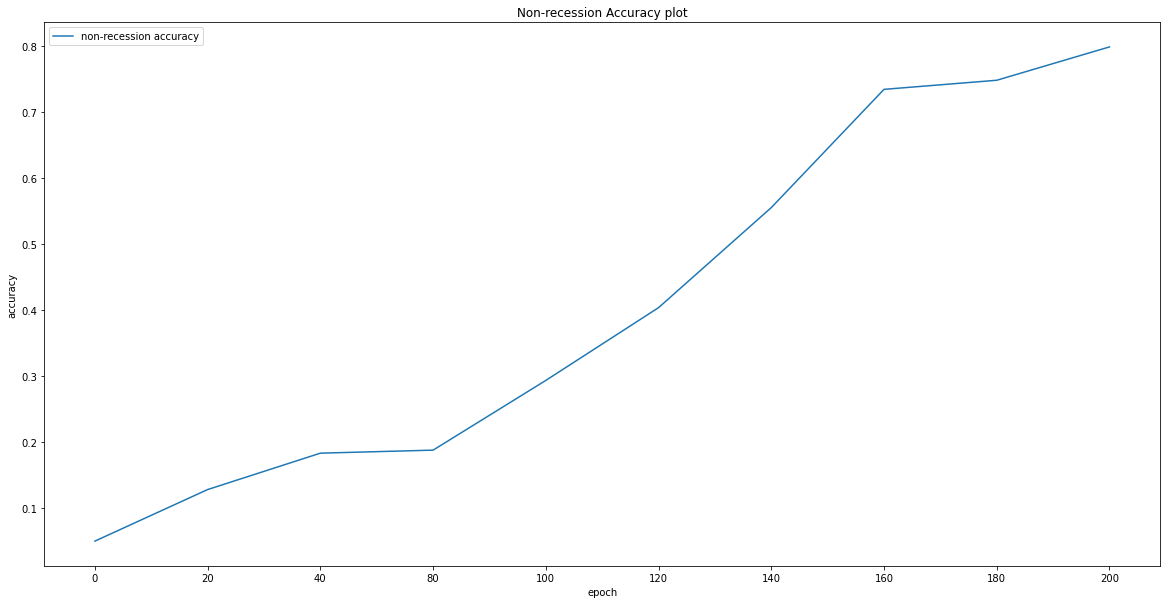

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

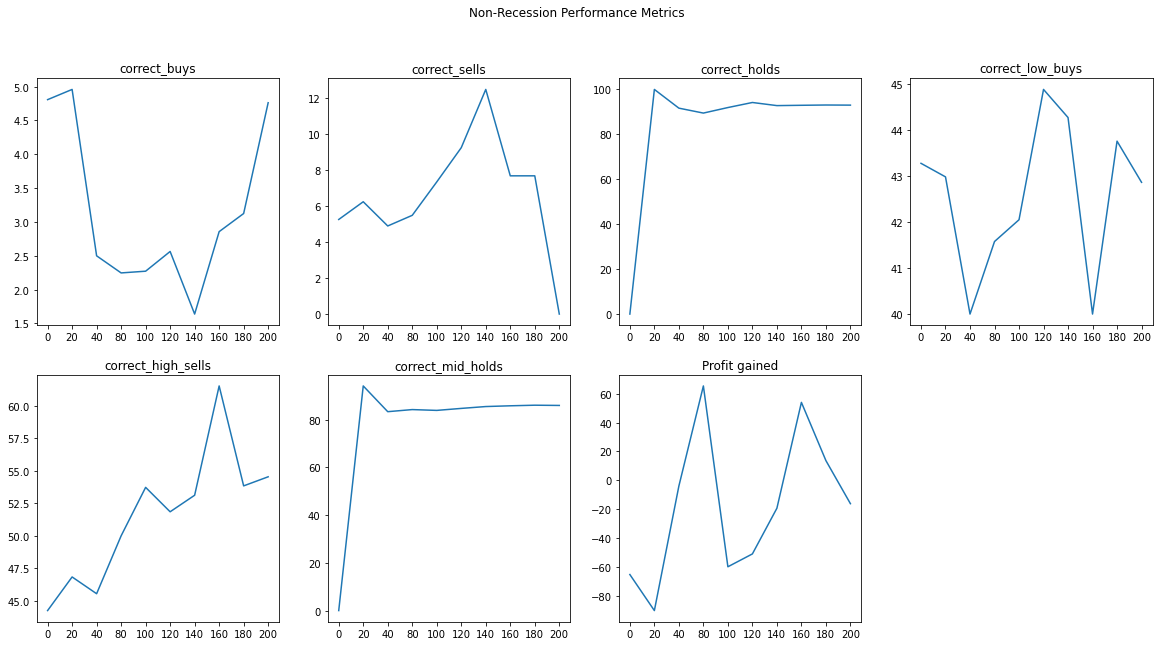

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

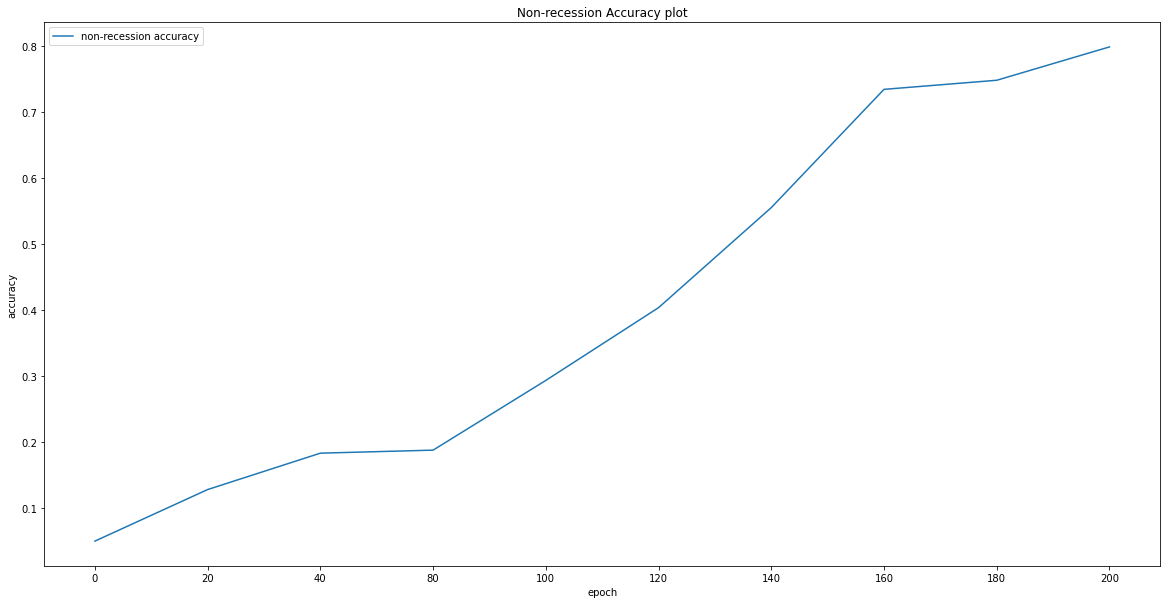

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

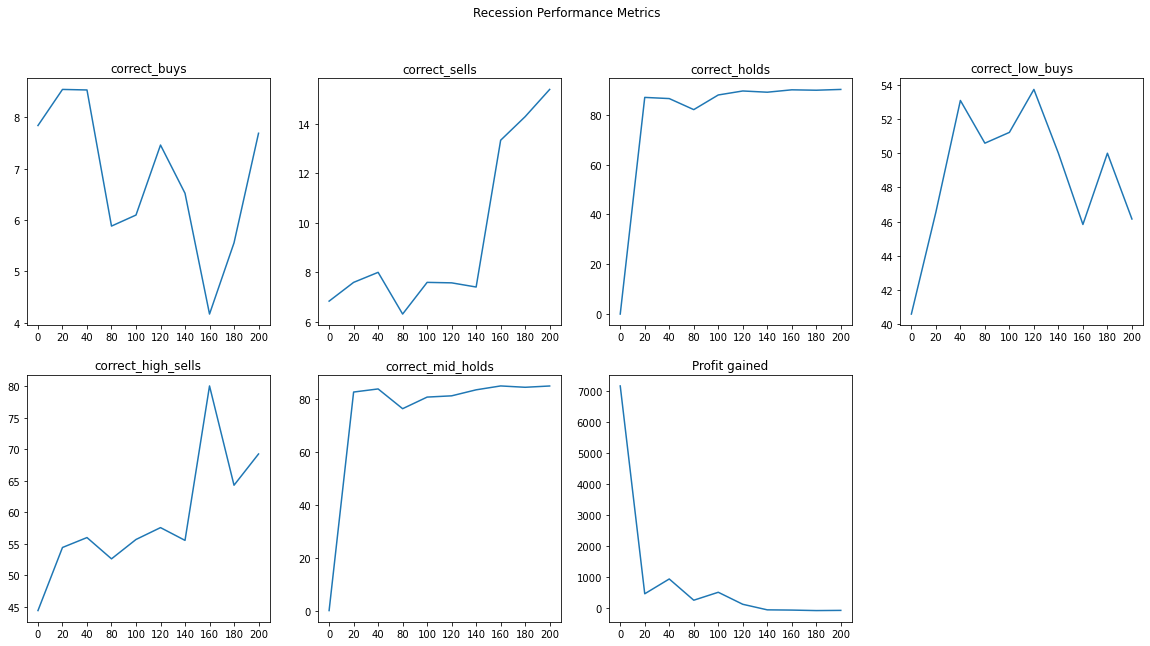

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")